In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import Client

sys.path.insert(0, 'tools/')

from tools import * 

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 20,Total memory: 31.04 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43847,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 31.04 GiB
Comm: tcp://127.0.0.1:42255,Total threads: 4
Dashboard: http://127.0.0.1:36061/status,Memory: 6.21 GiB
Nanny: tcp://127.0.0.1:43027,


# Merge

In [3]:
config = pd.Series({
    'path': os.path.abspath('dades'),
    'file_type':'csv',
    'years':[2019, 2021, 2022],
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [4]:
%%time

def read_data_all(cnfg:dict):

    data = dict()

    for year in cnfg.years:
        cnfg['year'] = year
        data[year] = load_checkpoint(cnfg)
    
    return dd.concat(list(data.values()), interleave_partitions=False)
    
bbdd_completa = read_data_all(config)   

checkpoint reloaded.
checkpoint reloaded.
checkpoint reloaded.
CPU times: user 134 ms, sys: 25 ms, total: 159 ms
Wall time: 154 ms


In [5]:
before = get_ddf_shape(bbdd_completa)
before

(12419994, 23)

In [6]:
%%time
# error fix
# 2019 gener, febrer and marc have the status reversed 

cond = (bbdd_completa.year == 2019) & (bbdd_completa.month.isin([1,2,3]))

bbdd_completa['status'] = bbdd_completa['status'].mask(cond, ((bbdd_completa['status'] + 1) %2))


CPU times: user 22.4 ms, sys: 0 ns, total: 22.4 ms
Wall time: 21.4 ms


In [7]:
%%time

bbdd_completa = bbdd_completa.drop(columns=['is_charging_station'])

# Found two station with alot of missing values 
# best solution is to remove
condition = (bbdd_completa['year'].isin([2020]))
bbdd_completa = bbdd_completa.mask(condition, np.nan)
bbdd_completa = bbdd_completa.dropna(subset=['year'])


CPU times: user 34.9 ms, sys: 0 ns, total: 34.9 ms
Wall time: 33.3 ms


In [8]:
after = get_ddf_shape(bbdd_completa)
after

(12419489, 22)

In [9]:
print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(after[0]-before[0]):02d} rows')
print(f'dropped {(after[1]-before[1]):02d} columns')

Changes to dataframe durinf preprocessing
dropeed -505 rows
dropped -1 columns


In [10]:
%%time

unique_ids_by_year = bbdd_completa.groupby('year')['station_id'].unique().compute()
print(unique_ids_by_year)

# Calcula los station_id comunes en todos los años
common_ids = set(unique_ids_by_year[2019])
for year, ids in unique_ids_by_year.items():
    print(year, ids.shape)
    common_ids = common_ids.intersection(set(ids))
# common_ids
print(len(common_ids))

filtered_bbdd = bbdd_completa[bbdd_completa['station_id'].isin(common_ids)]
nonfiltered_bbdd = bbdd_completa[~bbdd_completa['station_id'].isin(common_ids)]

year
2019.0    [1, 320, 319, 318, 317, 316, 315, 314, 313, 31...
2021.0    [1.0, 271.0, 400.0, 510.0, 26.0, 270.0, 269.0,...
2022.0    [1, 380, 28, 379, 378, 377, 376, 375, 29, 374,...
Name: station_id, dtype: object
2019.0 (410,)
2021.0 (509,)
2022.0 (510,)
408
CPU times: user 1.03 s, sys: 151 ms, total: 1.18 s
Wall time: 6.77 s


## General view

In [11]:
bbdd_completa.columns

Index(['station_id', 'num_docks_available', 'num_bikes_available', 'status',
       'timestamp', 'is_installed', 'is_renting', 'is_returning',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'year', 'month', 'dayofweek', 'day',
       'dayofyear', 'hour', 'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3',
       'ctx4'],
      dtype='object')

In [12]:

len(bbdd_completa.divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

37

In [13]:
bbdd_completa.head(2)

,station_id,num_docks_available,num_bikes_available,status,timestamp,is_installed,is_renting,is_returning,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,year,month,dayofweek,day,dayofyear,hour,capacity,ctx0,ctx1,ctx2,ctx3,ctx4
0,1,8.363636,17.636364,0,1546300800,1,1,1,17.636364,0.0,2019,1,1,1,1,0,46.0,0.181818,0.181818,0.181818,0.181818,0.181818
1,1,0.818182,26.181818,0,1546380000,1,1,1,26.181818,0.0,2019,1,1,1,1,22,46.0,0.017787,0.021739,0.023715,0.106719,0.094203


In [14]:
%%time

get_ddf_shape(bbdd_completa)

CPU times: user 1.6 s, sys: 116 ms, total: 1.72 s
Wall time: 7.07 s


(12419489, 22)

In [15]:
%%time

nans = get_features_nans(bbdd_completa)

zeros = get_features_zero(bbdd_completa)

CPU times: user 5.43 s, sys: 685 ms, total: 6.11 s
Wall time: 29.8 s


In [16]:
nans

{}

In [17]:
zeros

{'num_docks_available': 1.0849077606977227,
 'num_bikes_available': 6.601189469228565,
 'status': 96.44775239947472,
 'is_installed': 0.002713477180904947,
 'is_renting': 0.0620879007179764,
 'is_returning': 0.06201543396833799,
 'num_bikes_available_types.mechanical': 16.168338326963372,
 'num_bikes_available_types.ebike': 30.1792448948584,
 'dayofweek': 14.259668815681547,
 'hour': 4.314356250889227,
 'ctx0': 1.0849077606977227,
 'ctx1': 1.0829592103185566,
 'ctx2': 1.0801491108048005,
 'ctx3': 1.0772826482635478,
 'ctx4': 1.0744886524719335}

In [18]:
%%time 

uniques = get_columns_unique(bbdd_completa)

CPU times: user 21.5 s, sys: 3.2 s, total: 24.7 s
Wall time: 2min 27s


In [19]:
uniques

{'station_id': 0        1.0
 1      320.0
 2      319.0
 3      318.0
 4      317.0
        ...  
 507    446.0
 508     91.0
 509    467.0
 510     52.0
 511    431.0
 Name: station_id, Length: 512, dtype: float64,
 'num_docks_available': 0         8.363636
 1         0.818182
 2         0.000000
 3         6.818182
 4         7.909091
            ...    
 12302    24.370370
 12303    36.266667
 12304    19.151515
 12305     3.823529
 12306    24.433333
 Name: num_docks_available, Length: 12307, dtype: float64,
 'num_bikes_available': 0        17.636364
 1        26.181818
 2        27.000000
 3        21.181818
 4        20.181818
            ...    
 10374    29.333333
 10375     4.757576
 10376    24.176471
 10377     2.566667
 10378    52.708333
 Name: num_bikes_available, Length: 10379, dtype: float64,
 'status': 0    0.0
 1    1.0
 2    3.0
 3    2.0
 Name: status, dtype: float64,
 'timestamp': 0        1.546301e+09
 1        1.546380e+09
 2        1.546402e+09
 3        1.54641

# Station IDs

In [21]:
%%time

print(stats.describe(bbdd_completa.station_id))
bbdd_completa.station_id.describe().compute()

DescribeResult(nobs=12419489, minmax=(1.0, 519.0), mean=248.41091038447718, variance=20785.512916898646, skewness=0.06215743845031353, kurtosis=-1.1125387264818865)
CPU times: user 2.7 s, sys: 651 ms, total: 3.35 s
Wall time: 14.4 s


count    1.241949e+07
mean     2.484109e+02
std      1.441718e+02
min      1.000000e+00
25%      1.330000e+02
50%      2.630000e+02
75%      3.900000e+02
max      5.190000e+02
Name: station_id, dtype: float64

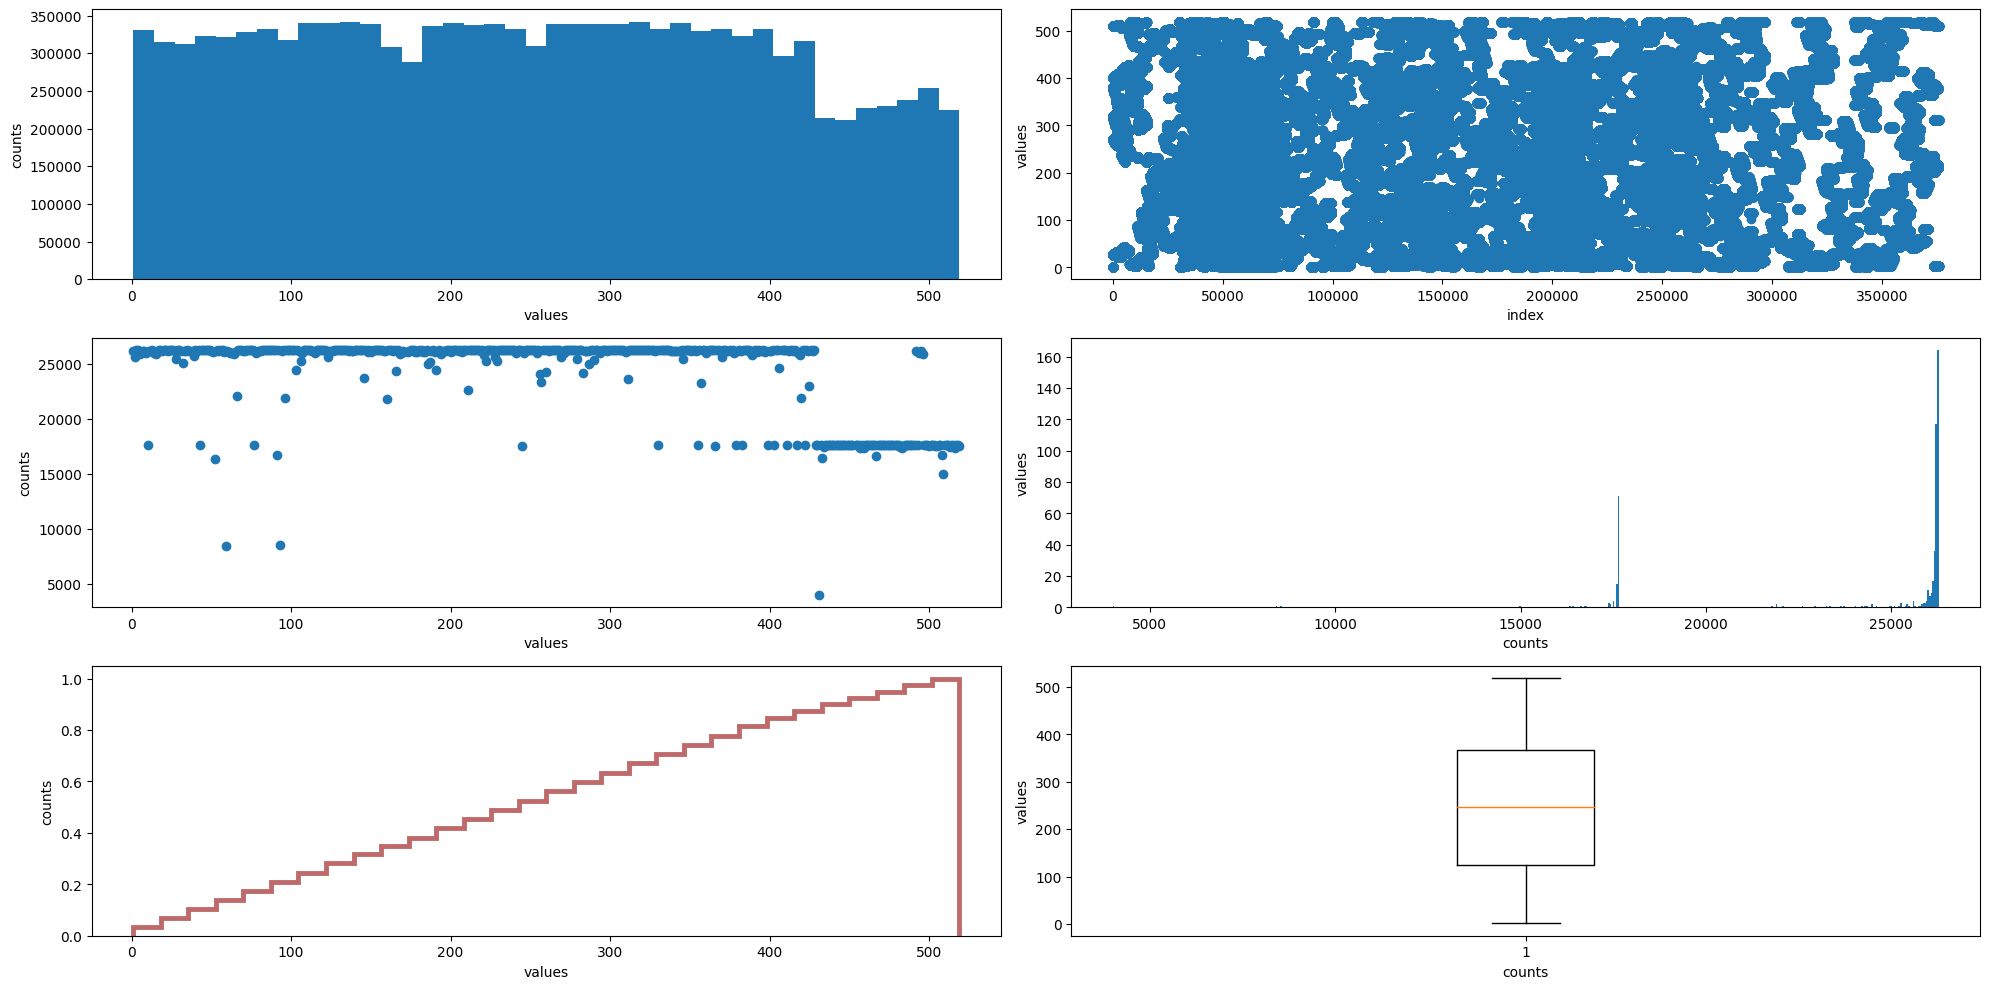

CPU times: user 19.3 s, sys: 1.97 s, total: 21.3 s
Wall time: 25 s


In [22]:
%%time

show_counts(bbdd_completa.station_id.compute())

# IDs comunes

In [23]:
%%time

get_ddf_shape(filtered_bbdd)
#bbdd_completa.shape = (12531377, 23)

CPU times: user 1.78 s, sys: 188 ms, total: 1.97 s
Wall time: 8.26 s


(10627655, 22)

In [24]:
xticks = np.asanyarray(
    (
        uniques['timestamp'].min(), 
        np.round(uniques['timestamp'].mean()-uniques['timestamp'].std()).astype(int),
        np.round(uniques['timestamp'].mean()).astype(int),
        np.round(uniques['timestamp'].mean()+uniques['timestamp'].std()).astype(int),
        uniques['timestamp'].max()
    )
)
xticks

array([1.54630080e+09, 1.57463877e+09, 1.61498426e+09, 1.65532975e+09,
       1.67252760e+09])

value counts stats {'max': 26279, 'mean': 26048.174019607843, 'median': 26225.5, 'std': 619.8524803587534, 'min': 21796}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 6.3 s, sys: 938 ms, total: 7.23 s
Wall time: 45.2 s


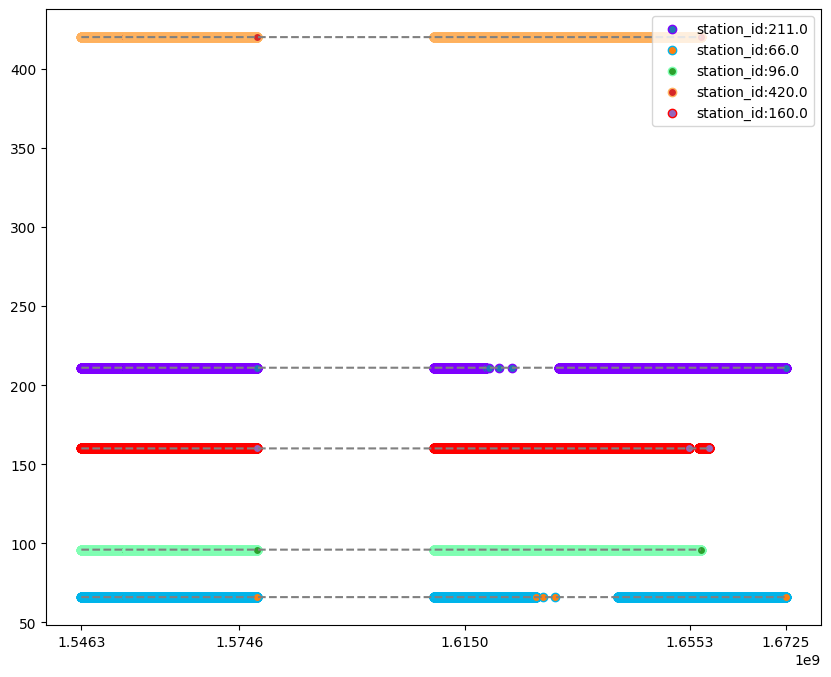

In [25]:
%%time

scatter_columns(
    filtered_bbdd, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8)
)

## IDs no comunes (testing)

In [26]:
%%time

get_ddf_shape(nonfiltered_bbdd)
#bbdd_completa.shape = (12531377, 23)

CPU times: user 1.71 s, sys: 181 ms, total: 1.9 s
Wall time: 7.94 s


(1791834, 22)

value counts stats {'max': 17641, 'mean': 17229.173076923078, 'median': 17633.0, 'std': 1841.213948650456, 'min': 3998}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 6.35 s, sys: 840 ms, total: 7.19 s
Wall time: 45.1 s


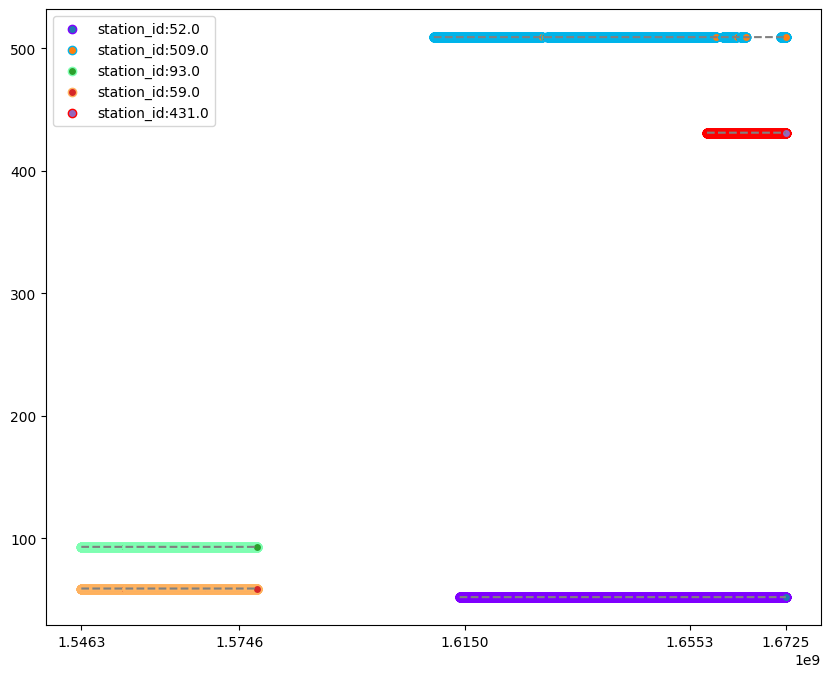

In [27]:
%%time

scatter_columns(
    nonfiltered_bbdd, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8)
)

In [ ]:
.
do not run the following cells

# Data exploration__________________________________

## · Descriptiva
Media, mediana, desviación estándar, mínimo y máximo para columnas numéricas Idea general de la distribución y el rango de los valores en esas columnas.

<div>
    <table>
        <tr>
            <th><p>Camp<p><th>
            <th><p>Descripció<p><th>
        <tr>
        <tr>
            <td><p>last_updated<p><td>
            <td><p>Timestamp de l'arxiu<p><td>
        <tr>
        <tr>
            <td><p>ttl<p><td>
            <td><p>TimeToLive de la resposta<p><td>
        <tr>
        <tr>
            <td><p>data<p><td>
            <td><p>Contenidor d'arrays d'informació d'estacions<p><td>
        <tr>
        <tr>
            <td><p>stations<p><td>
            <td><p>Array de dades de cada estació<p><td>
        <tr>
        <tr>
            <td><p>station_id<p><td>
            <td><p>Identificador de l'estació<p><td>
        <tr>
        <tr>
            <td><p>num_bikes_available<p><td>
            <td><p>Nombre de bicicletes disponibles<p><td>
        <tr>
        <tr>
            <td><p>num_bikes_available_types<p><td>
            <td><p>Array de tipus de bicicletes disponibles<p><td>
        <tr>
        <tr>
            <td><p>mechanical<p><td>
            <td><p>Nombre de bicicletes mecàniques disponibles<p><td>
        <tr>
        <tr>
            <td><p>ebike<p><td>
            <td><p>Nombre de bicicletes elèctriques disponibles<p><td>
        <tr>
        <tr>
            <td><p>num_docks_available<p><td>
            <td><p>Nombre de ancoratges disponibles<p><td>
        <tr>
        <tr>
            <td><p>is_installed<p><td>
            <td><p>L'estació està correctament instalada (0-NO,1-SI)<p><td>
        <tr>
        <tr>
            <td><p>is_renting<p><td>
            <td><p>L'estació està proporcionant bicicletes correctament<p><td>
        <tr>
        <tr>
            <td><p>is_returning<p><td>
            <td><p>L'estació està ancorant bicicletes correctament<p><td>
        <tr>
        <tr>
            <td><p>last_reported<p><td>
            <td><p>Timestamp de la informació de l'estació<p><td>
        <tr>
        <tr>
            <td><p>is_charging_station<p><td>
            <td><p>L'estació té capacitat de càrrega de bicicletes elèctriques<p><td>
        <tr>
        <tr>
            <td><p>status<p><td>
            <td><p>
                Estat de l'estació (IN_SERVICE=En servei, CLOSED=Tancada)
                 ['IN_SERVICE', 'OPEN', 'OPN', 'CLS', 'CLOSED', 'NOT_IN_SERVICE', 'MAINTENANCE', 'PLANNED']                     [0, 0, 0, 1, 1, 1,  2, 3]
                <p><td>
        <tr>
    <table>
<div>

# Time columns 

## 'timestamp'

DescribeResult(nobs=10627655, minmax=(1546300800.0, 1672527600.0), mean=1615284637.3199356, variance=1622926949978758.0, skewness=-0.37869578885623373, kurtosis=-1.32752802455335)


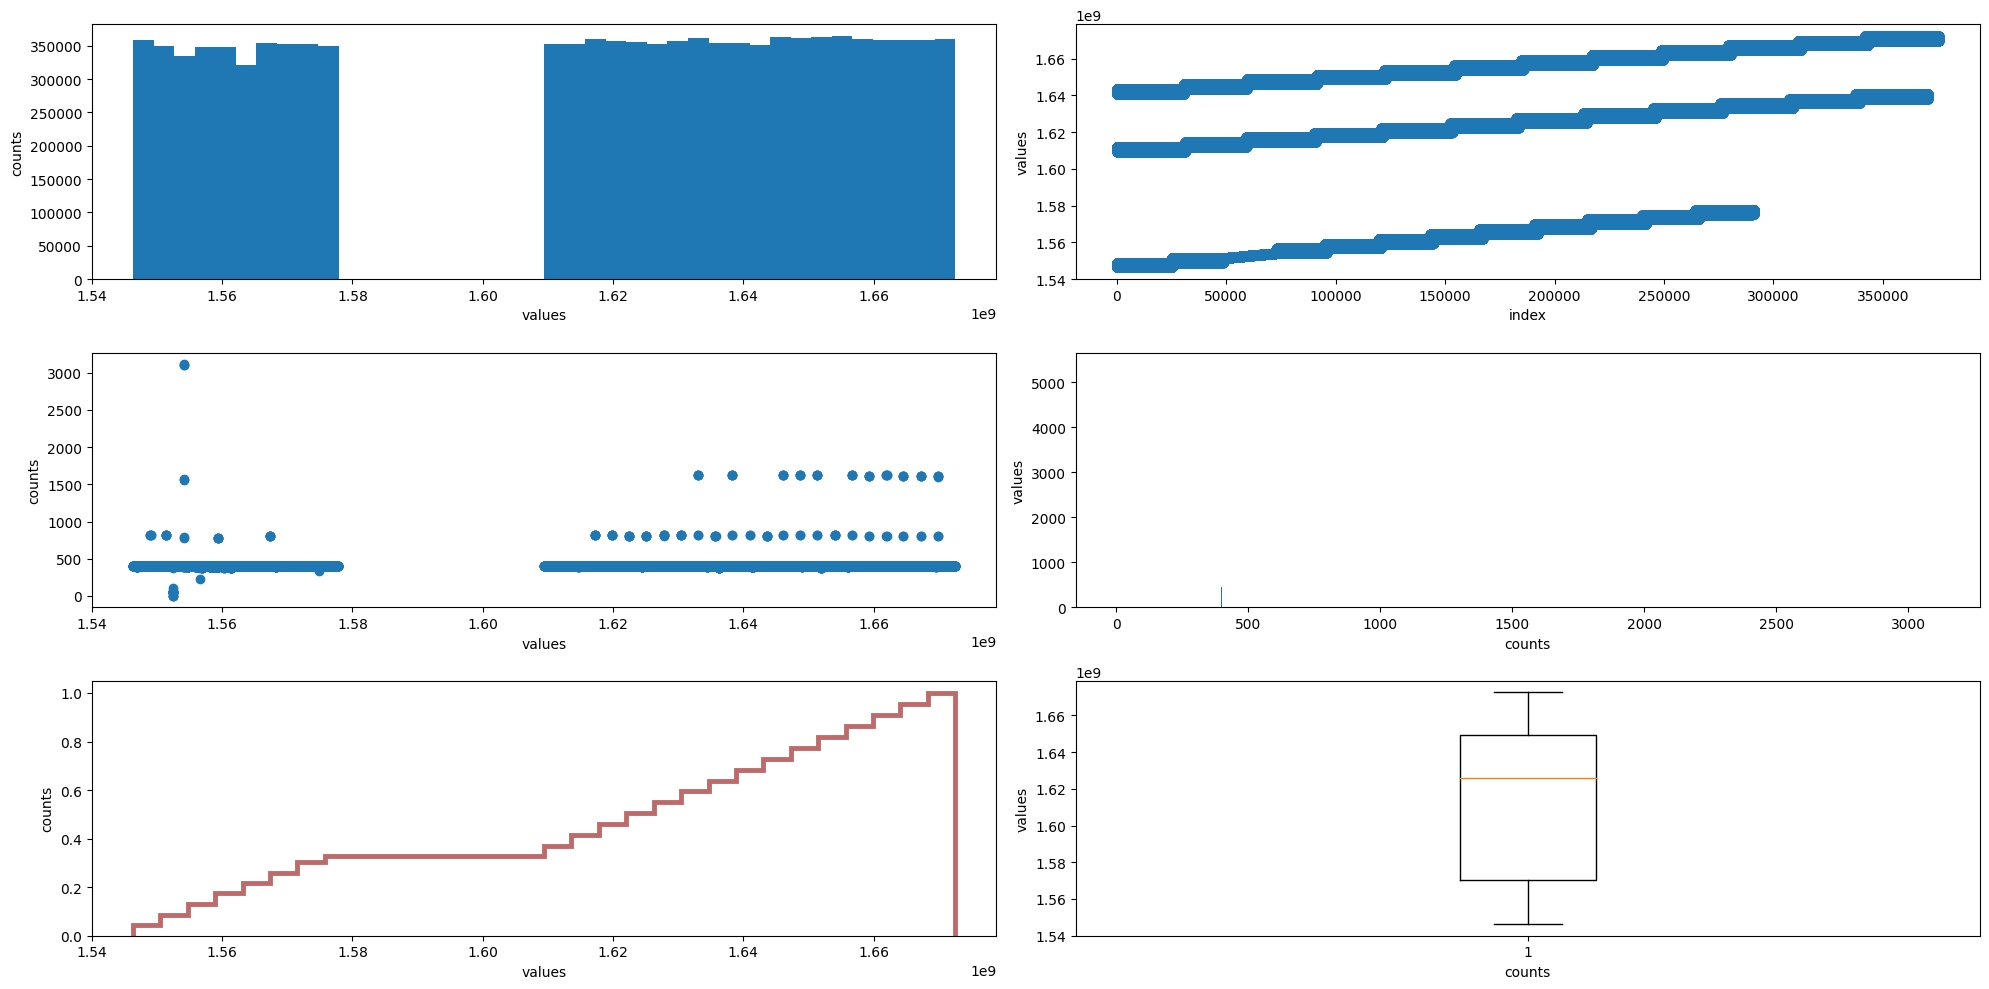

CPU times: user 45.7 s, sys: 5.59 s, total: 51.3 s
Wall time: 59.5 s


In [28]:
%%time
print(stats.describe(filtered_bbdd.timestamp))
filtered_bbdd.timestamp.describe()

show_counts(filtered_bbdd.timestamp.compute())

## 'year' 

DescribeResult(nobs=10627655, minmax=(2019.0, 2022.0), mean=2020.6853544831856, variance=1.5456501511925502, skewness=-0.40788408919894786, kurtosis=-1.472671488707758)


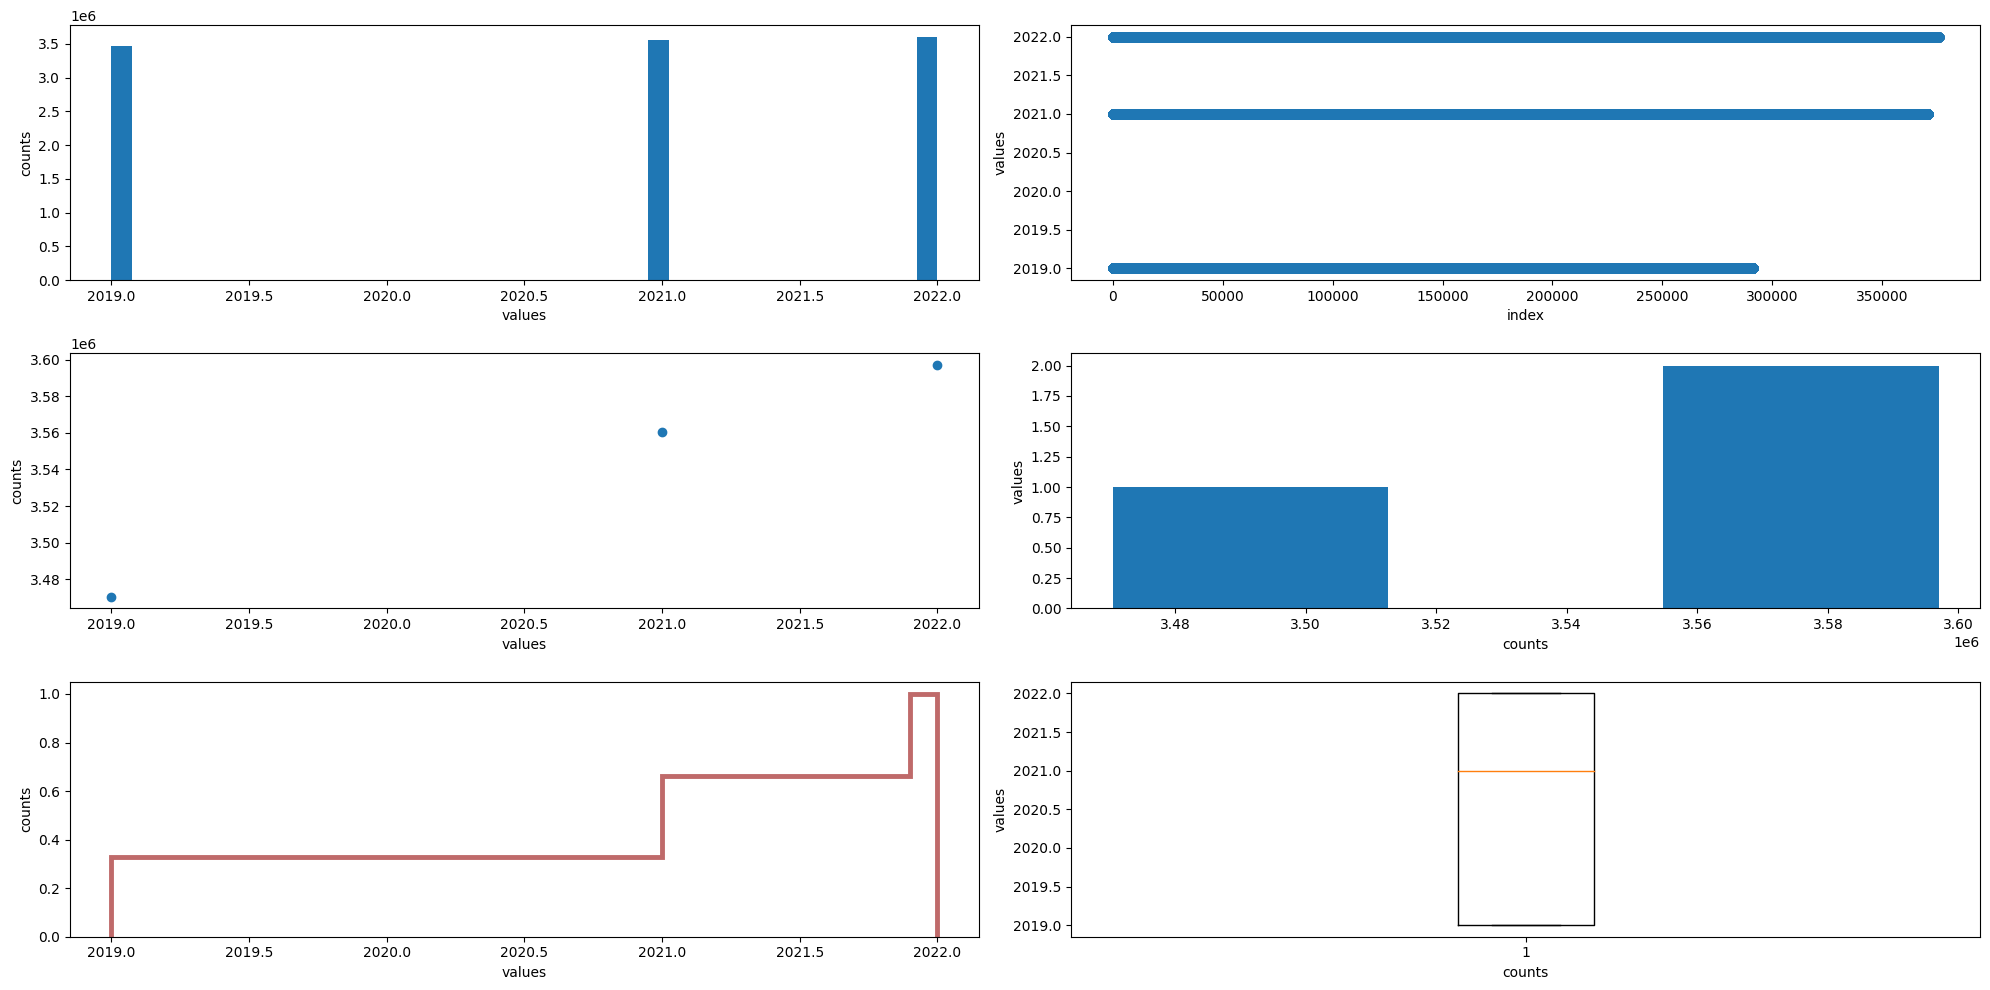

CPU times: user 17.5 s, sys: 1.34 s, total: 18.9 s
Wall time: 31 s


In [29]:
%%time
print(stats.describe(filtered_bbdd.year))
filtered_bbdd.year.describe()
show_counts(filtered_bbdd.year.compute())

## 'month'

DescribeResult(nobs=10627655, minmax=(1.0, 12.0), mean=6.530022474384048, variance=11.924144550070244, skewness=-0.012948642869240681, kurtosis=-1.2136207767733824)


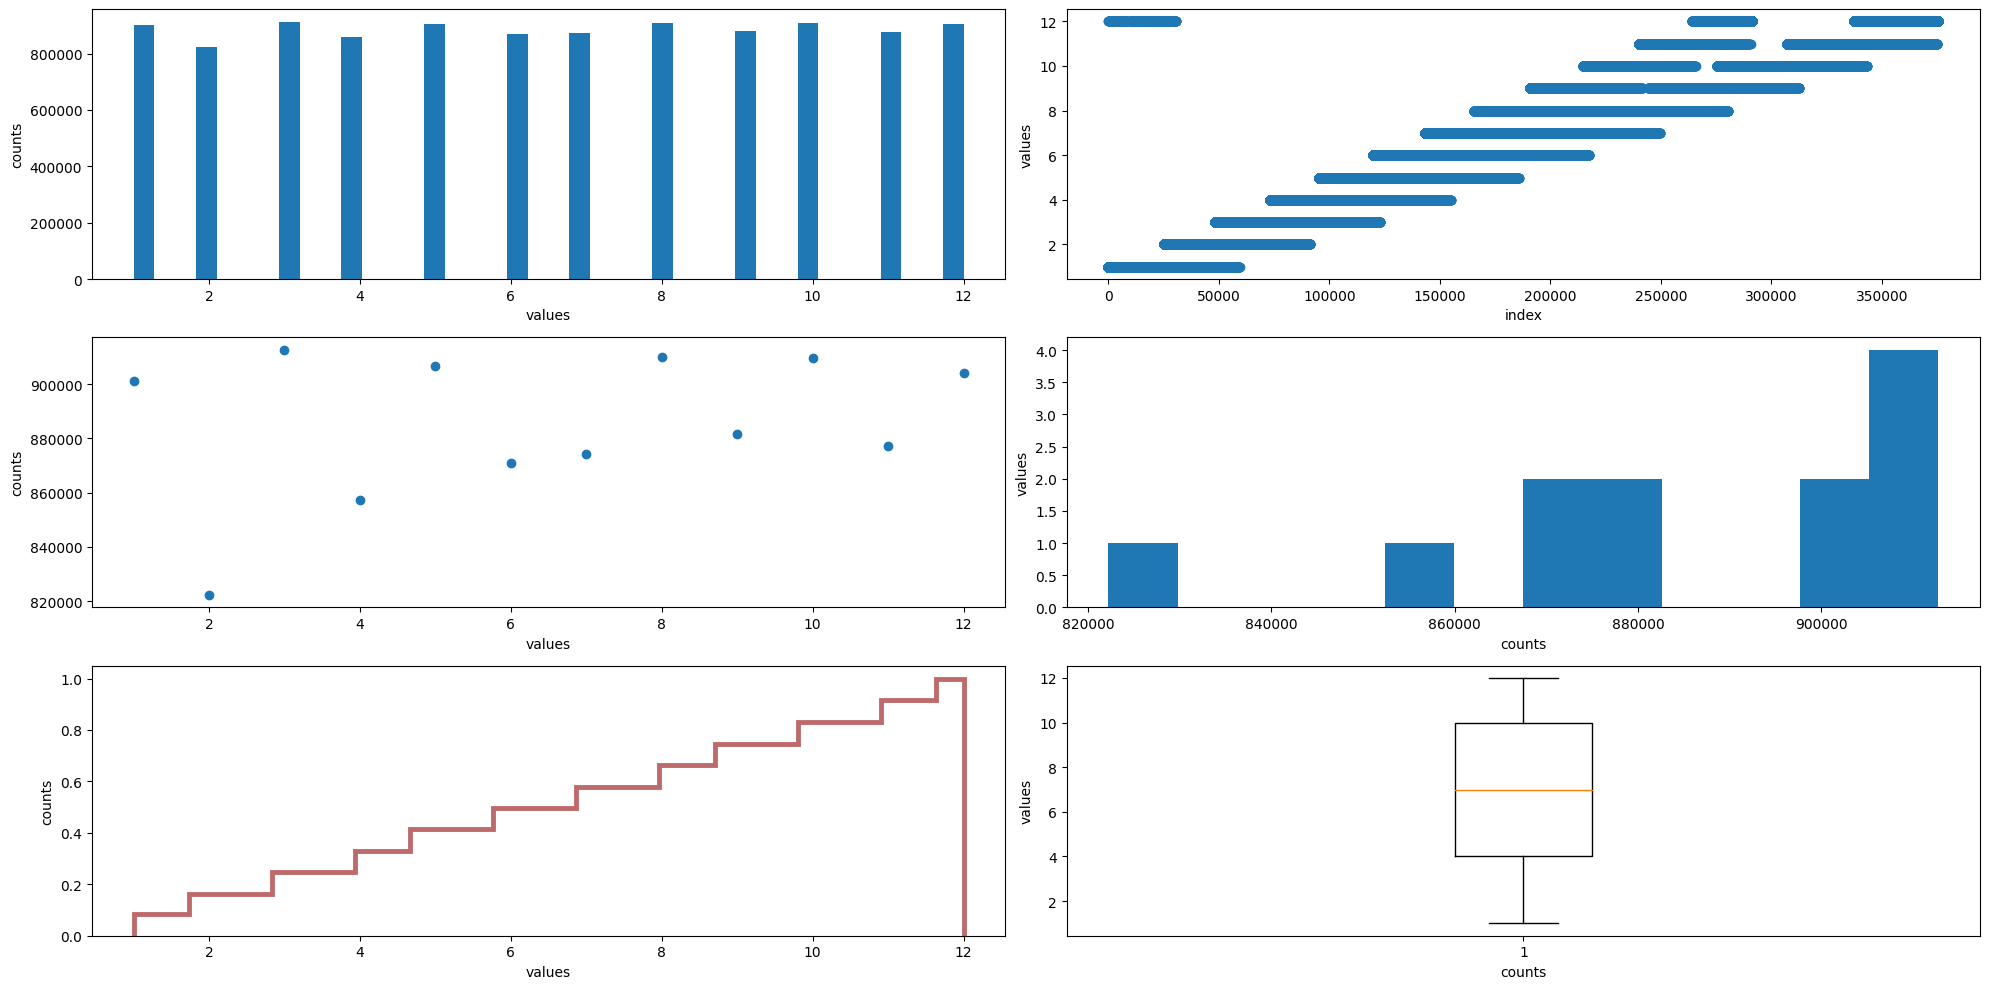

CPU times: user 17.7 s, sys: 1.29 s, total: 18.9 s
Wall time: 31.2 s


In [30]:
%%time
print(stats.describe(filtered_bbdd.month))
filtered_bbdd.month.describe()
show_counts(filtered_bbdd.month.compute())

## 'dayofweek' 

DescribeResult(nobs=10627655, minmax=(0.0, 6.0), mean=3.0008185248768426, variance=4.001291336700663, skewness=-0.0016629520339737625, kurtosis=-1.2516386389631011)


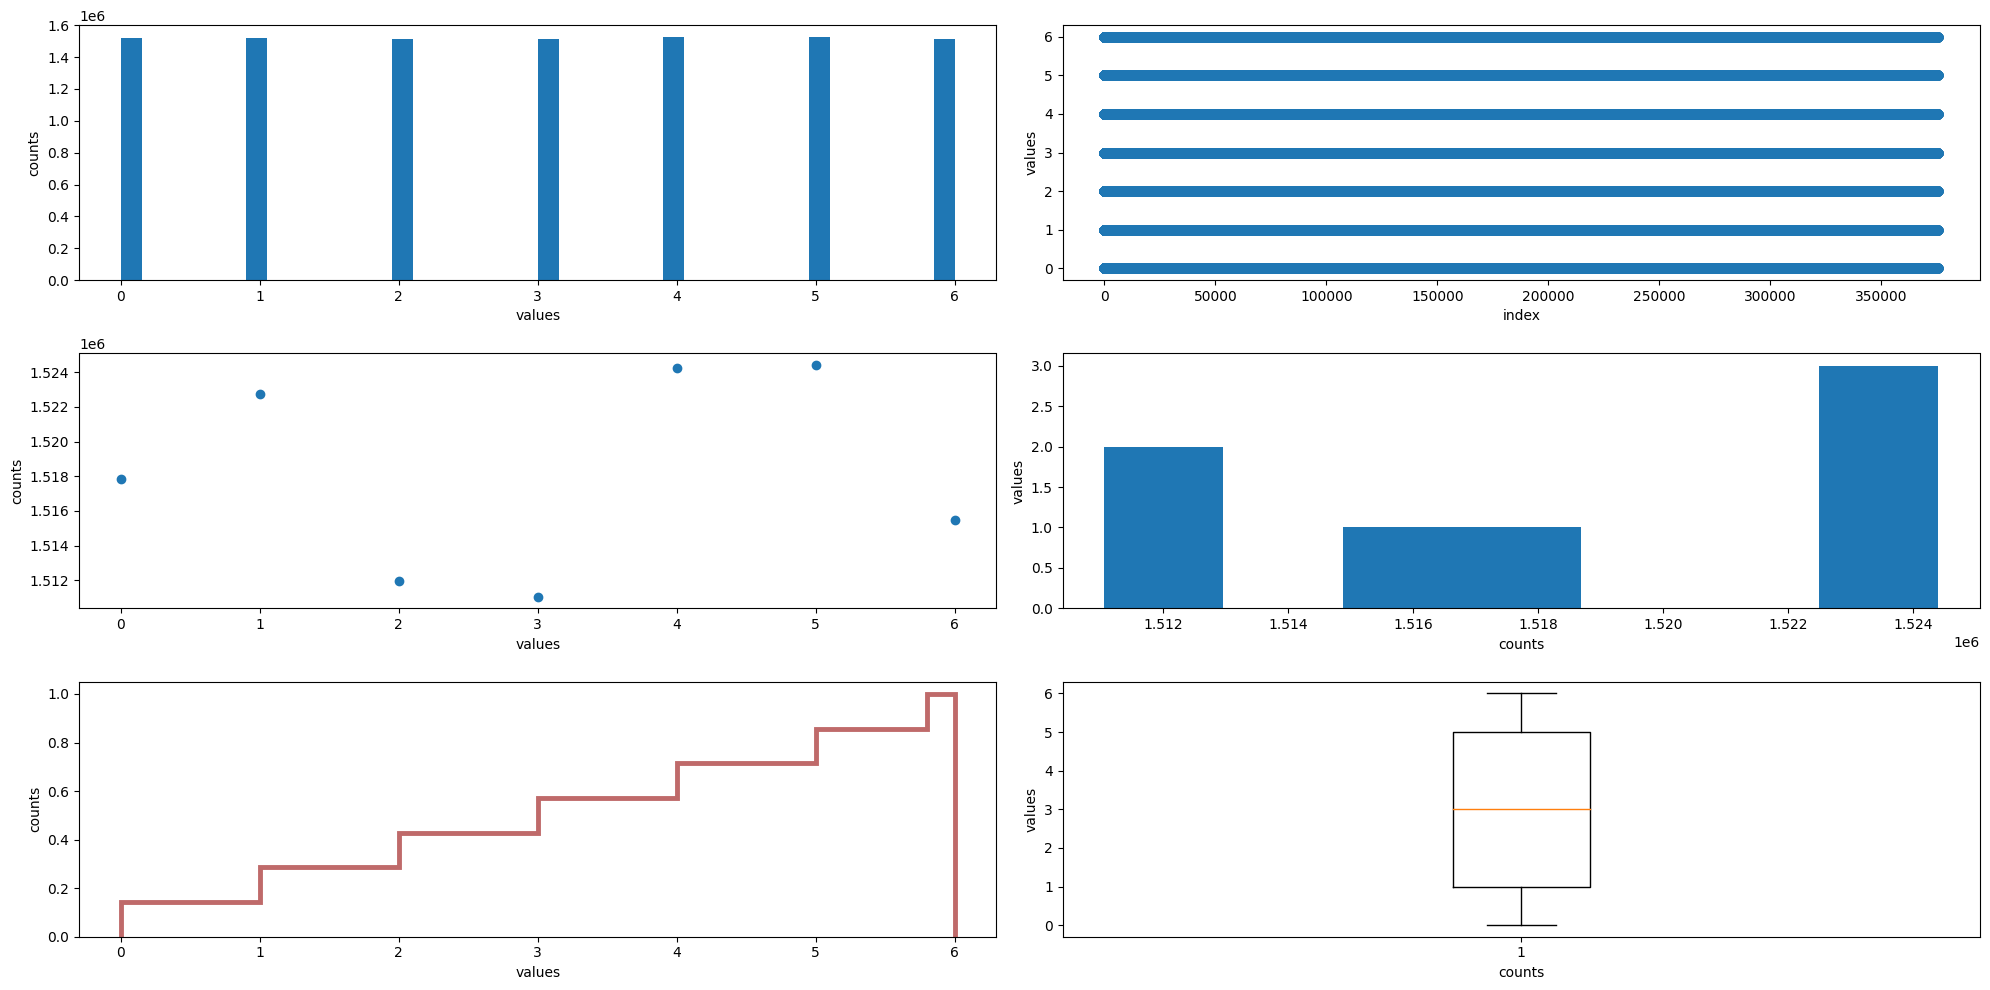

CPU times: user 18.1 s, sys: 1.23 s, total: 19.3 s
Wall time: 31.7 s


In [31]:
%%time
print(stats.describe(filtered_bbdd.dayofweek))
filtered_bbdd.dayofweek.describe()
show_counts(filtered_bbdd.dayofweek.compute())

## 'day'

DescribeResult(nobs=10627655, minmax=(1.0, 31.0), mean=15.713647083952198, variance=78.4113511434141, skewness=0.005976901776083137, kurtosis=-1.190947986478895)


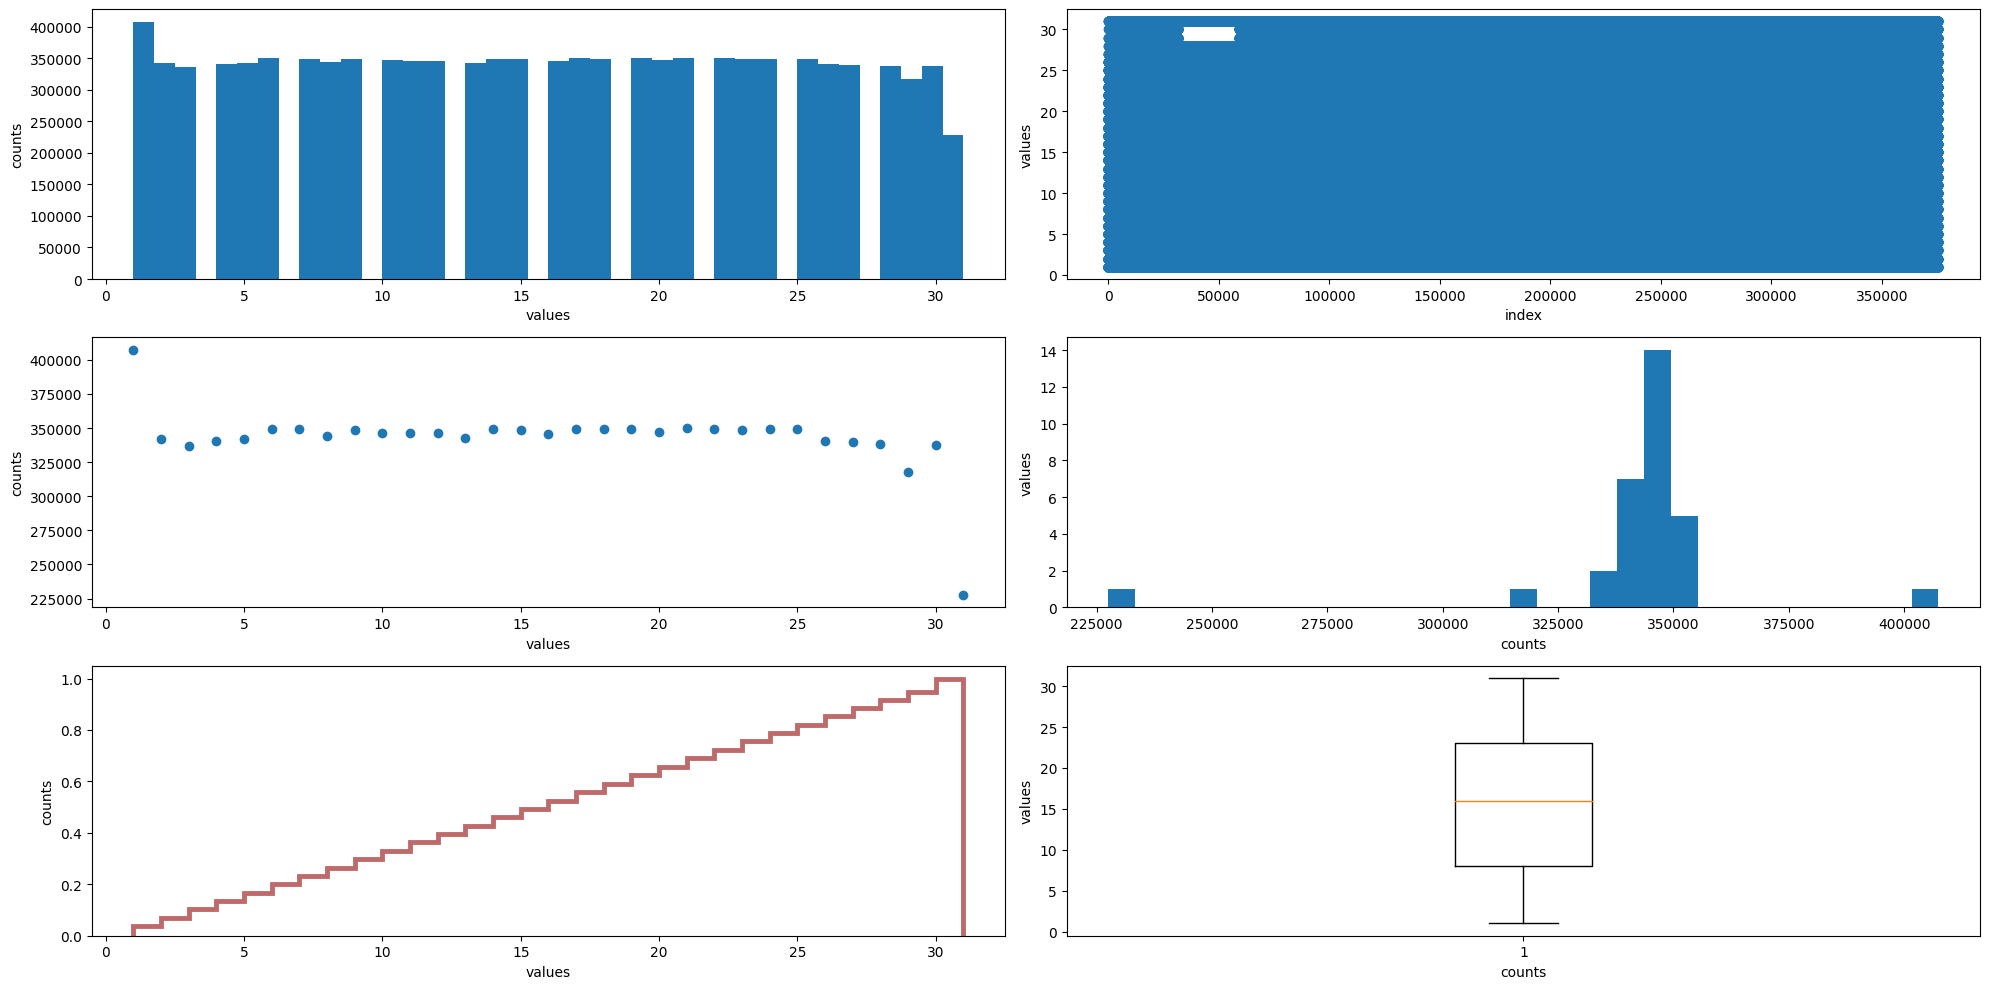

CPU times: user 18.5 s, sys: 1.29 s, total: 19.8 s
Wall time: 32.2 s


In [32]:
%%time
print(stats.describe(filtered_bbdd.day))
filtered_bbdd.day.describe()
show_counts(filtered_bbdd.day.compute())

## 'dayofyear' 

DescribeResult(nobs=10627655, minmax=(1.0, 365.0), mean=183.11725512354326, variance=11127.5090720755, skewness=-0.0017764241943876015, kurtosis=-1.2053052586300066)


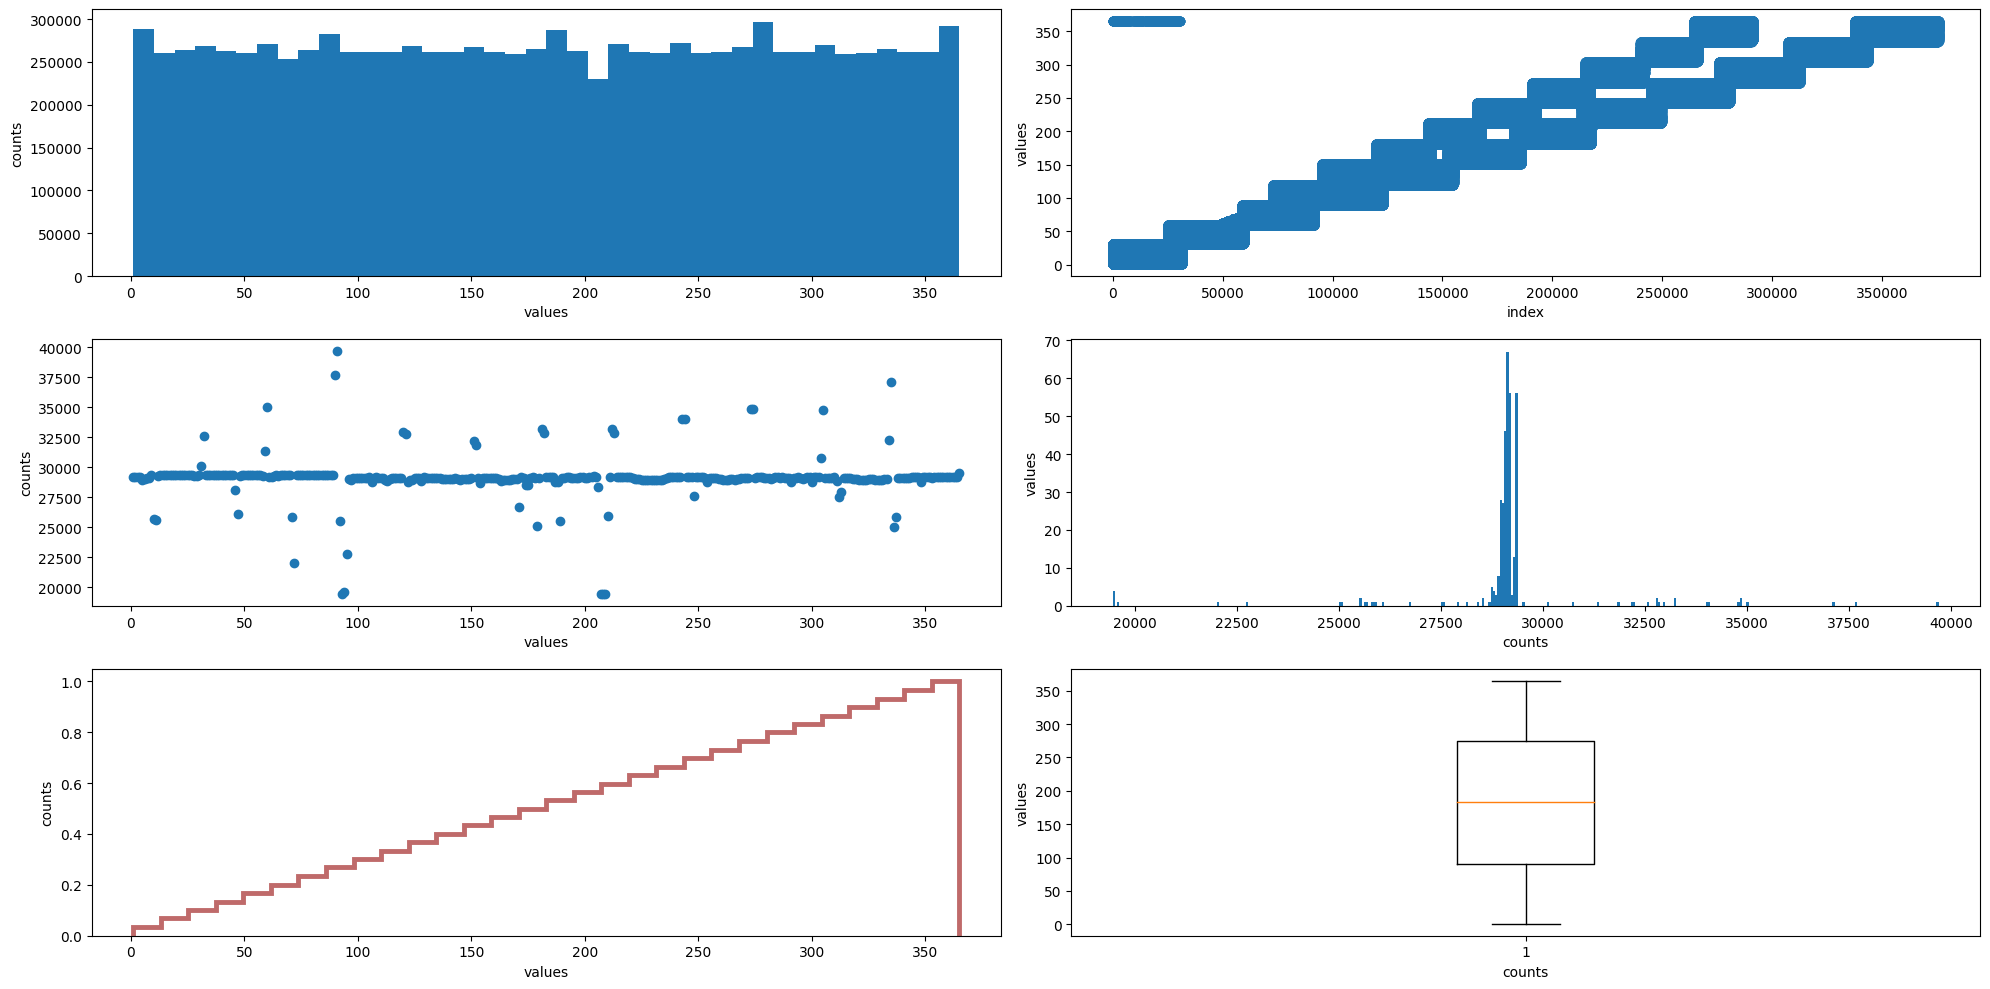

CPU times: user 18.2 s, sys: 1.26 s, total: 19.4 s
Wall time: 32.5 s


In [33]:
%%time
print(stats.describe(filtered_bbdd.dayofyear))
filtered_bbdd.dayofyear.describe()
show_counts(filtered_bbdd.dayofyear.compute())

## 'hour'

DescribeResult(nobs=10627655, minmax=(0.0, 23.0), mean=11.4948269397153, variance=48.496993913057175, skewness=0.00014045523031829378, kurtosis=-1.2117985778800915)


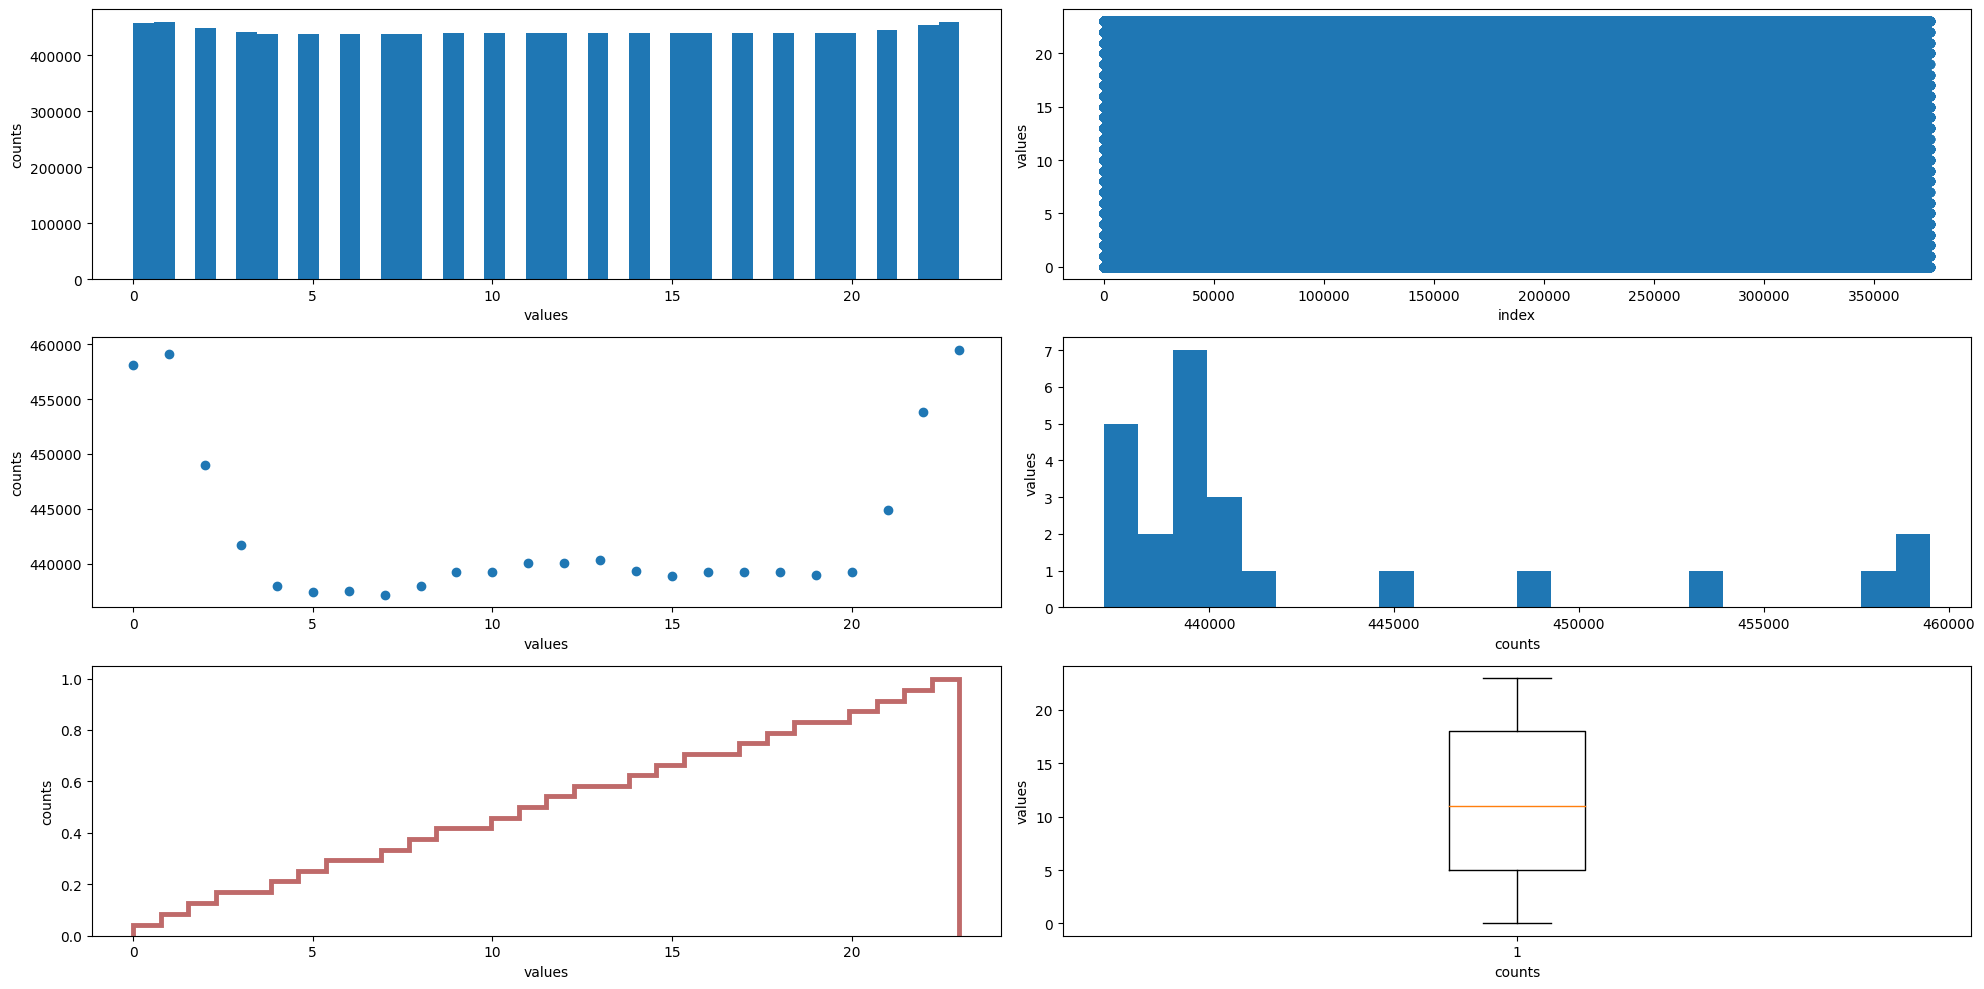

CPU times: user 18 s, sys: 1.38 s, total: 19.4 s
Wall time: 31.6 s


In [34]:
%%time
print(stats.describe(filtered_bbdd.hour))
filtered_bbdd.hour.describe()
show_counts(filtered_bbdd.hour.compute())

# Status Columns 

## 'status'

DescribeResult(nobs=10627655, minmax=(0.0, 3.0), mean=0.041348538318189666, variance=0.03993166140133433, skewness=4.6817704680103684, kurtosis=20.66732746441674)


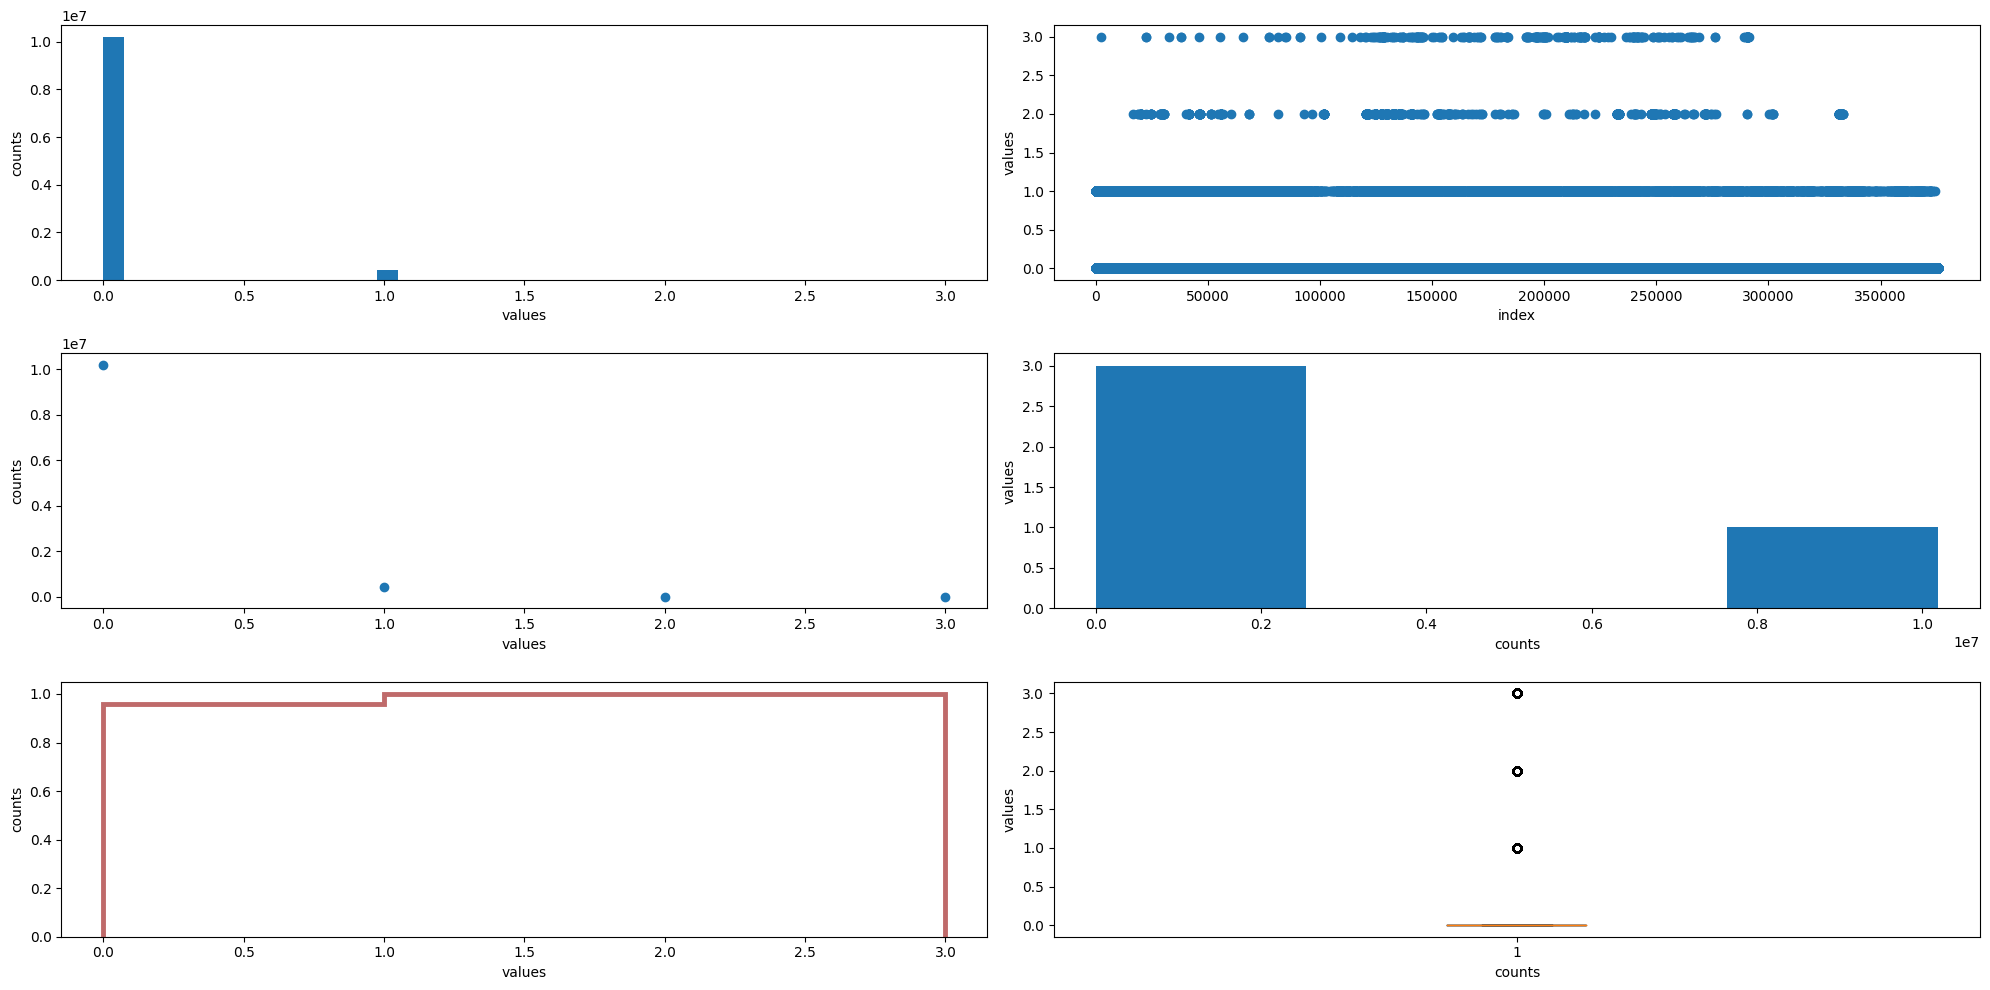

CPU times: user 17.7 s, sys: 1.26 s, total: 18.9 s
Wall time: 31.3 s


In [35]:
%%time
print(stats.describe(filtered_bbdd.status))
filtered_bbdd.status.describe()
show_counts(filtered_bbdd.status.compute())

## 'is_installed'

DescribeResult(nobs=10627655, minmax=(0.0, 1.0), mean=0.9999696075945258, variance=3.0391484635559444e-05, skewness=-181.38345207525043, kurtosis=32897.95668673732)


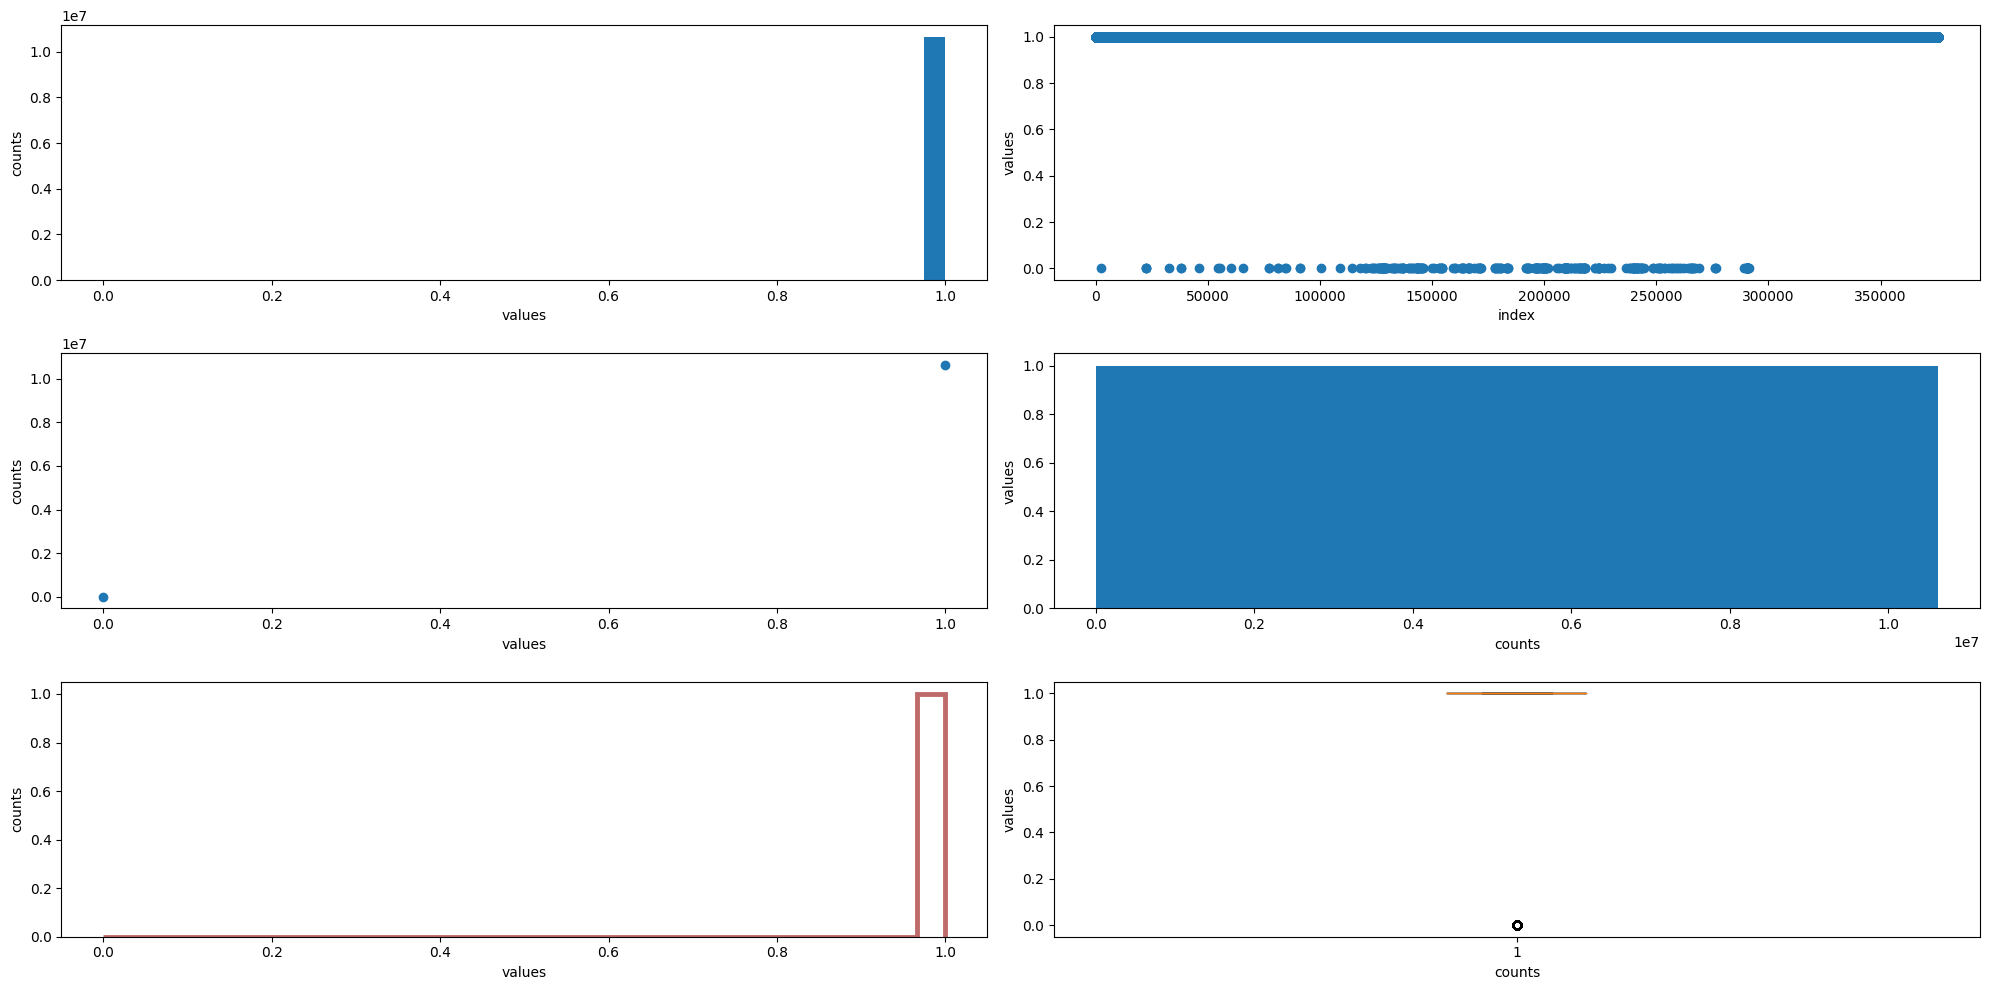

CPU times: user 17.5 s, sys: 1.29 s, total: 18.8 s
Wall time: 31.1 s


In [36]:
%%time
print(stats.describe(filtered_bbdd.is_installed))
filtered_bbdd.is_installed.describe()
show_counts(filtered_bbdd.is_installed.compute())

## 'is_renting'

DescribeResult(nobs=10627655, minmax=(0.0, 1.0), mean=0.999375591322827, variance=0.0006240188496932923, skewness=-39.98144375595833, kurtosis=1596.515844810848)


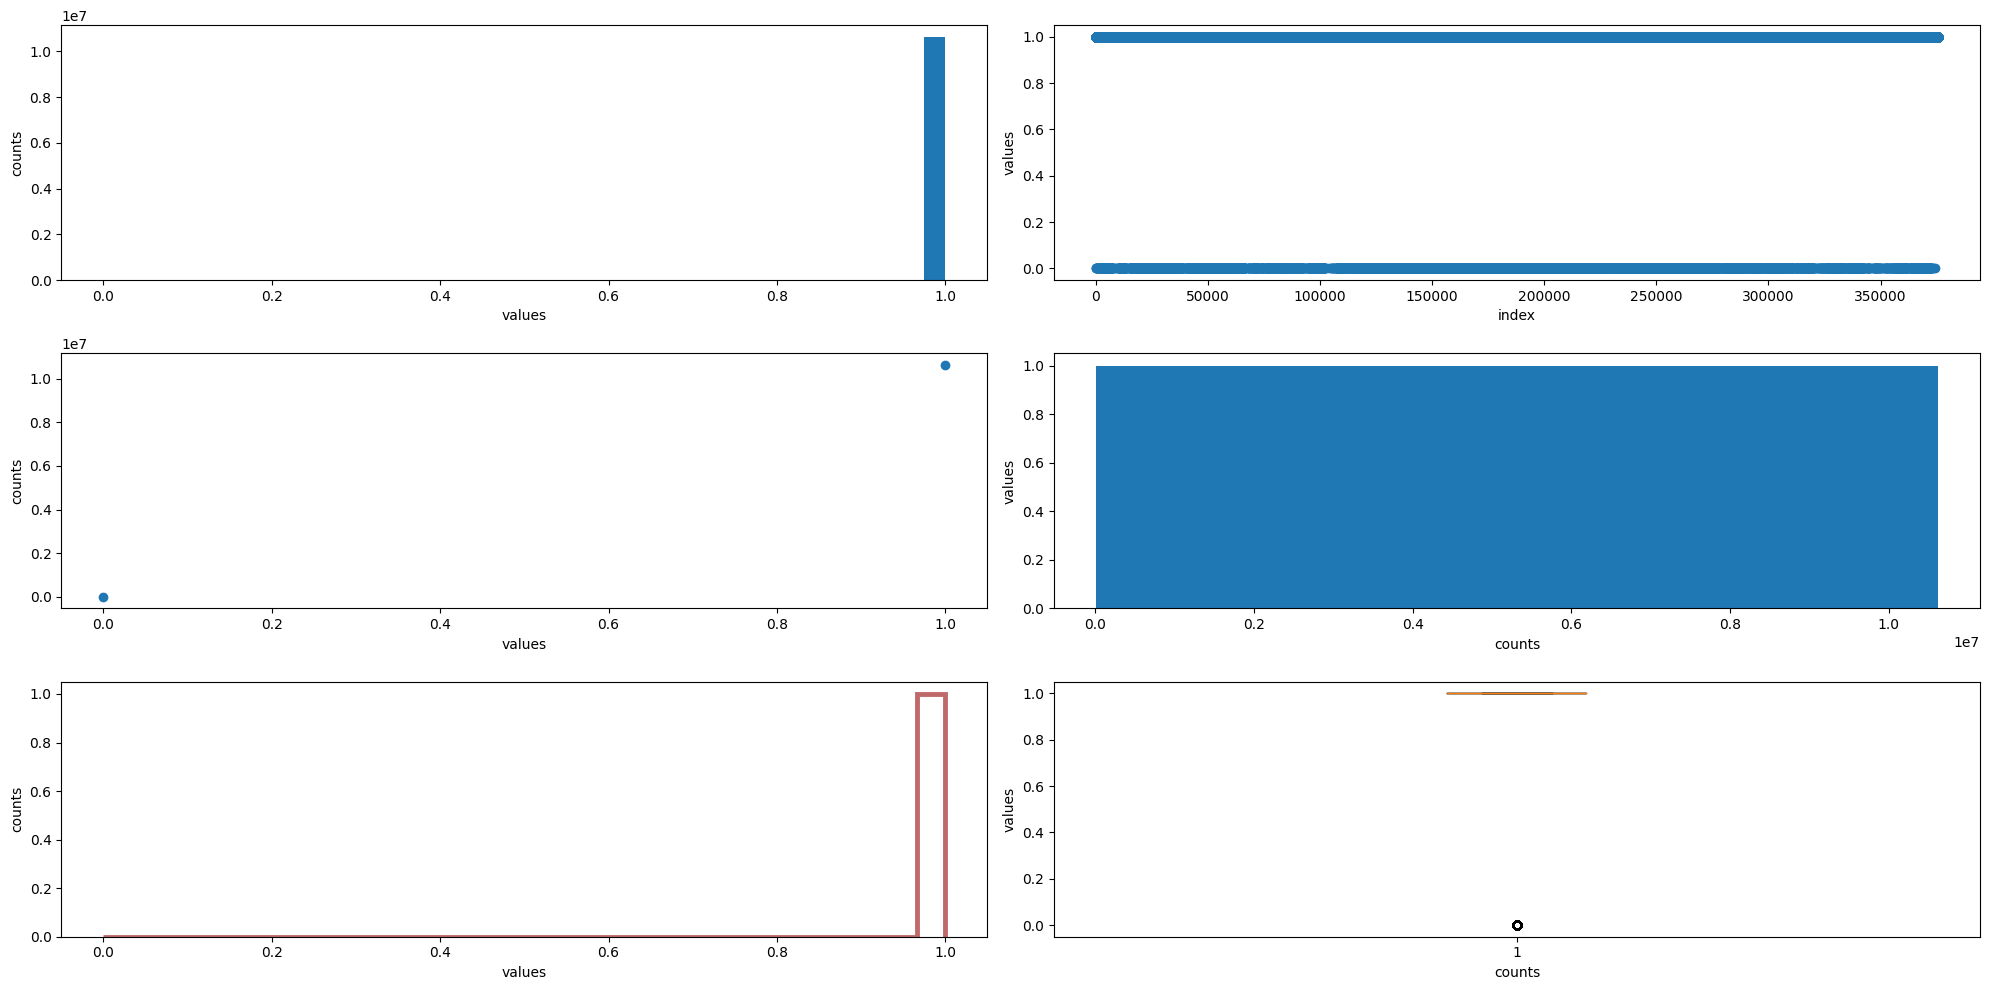

CPU times: user 17.8 s, sys: 1.19 s, total: 18.9 s
Wall time: 31.2 s


In [37]:
%%time
print(stats.describe(filtered_bbdd.is_renting))
filtered_bbdd.is_renting.describe()
show_counts(filtered_bbdd.is_renting.compute())

## 'is_returning'

DescribeResult(nobs=10627655, minmax=(0.0, 1.0), mean=0.9993764381700384, variance=0.0006231730592426935, skewness=-40.00863445158983, kurtosis=1598.6908306809341)


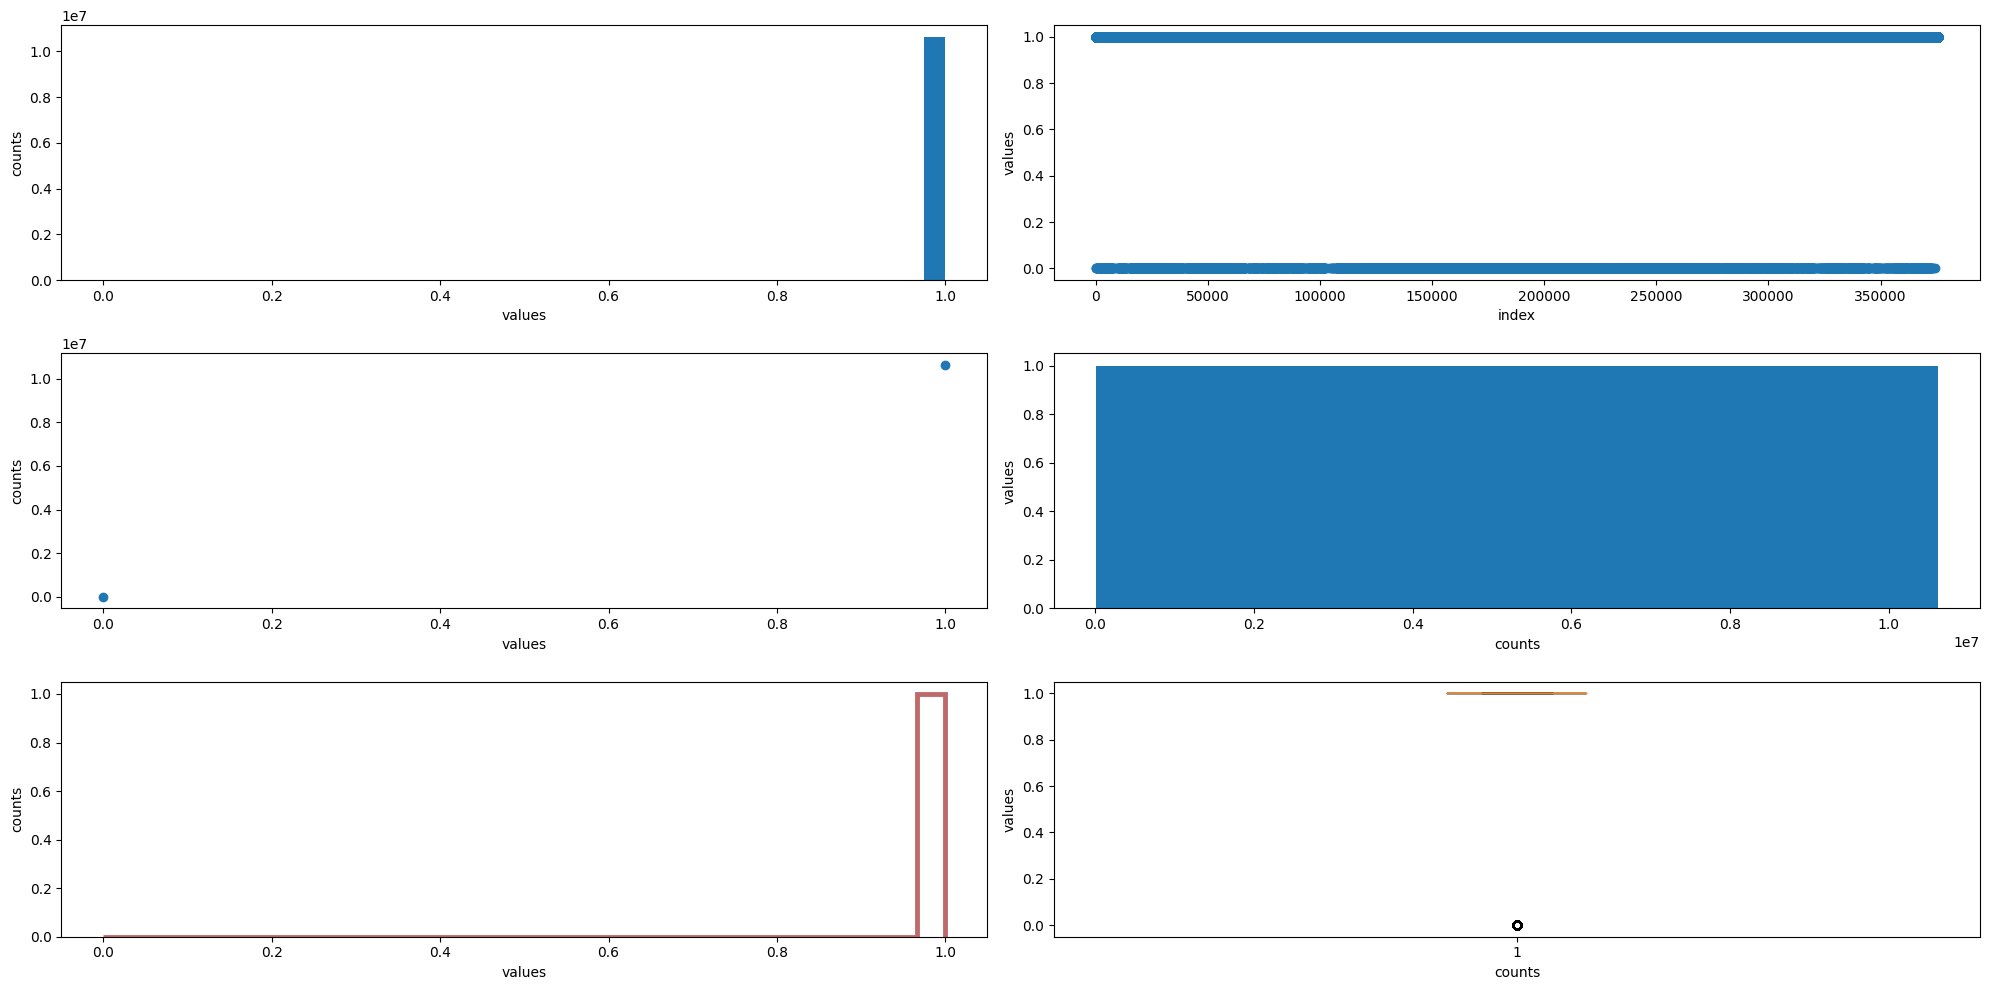

CPU times: user 17.6 s, sys: 1.09 s, total: 18.7 s
Wall time: 31 s


In [38]:
%%time
print(stats.describe(filtered_bbdd.is_returning))
filtered_bbdd.is_returning.describe()
show_counts(filtered_bbdd.is_returning.compute())

## 'is_charging_station'

## Study 

In [40]:
def filter_data(data, row_data, row_index):
    cat_cols = row_data.select_dtypes(include=['object']).columns
    num_cols = row_data.select_dtypes(exclude=['object']).columns
    
    filtered = data.copy()
    
    row = row_data.loc[row_index]
    for num_col in num_cols:
        filtered = filtered[filtered[num_col] == row[num_col]]
    
    for cat_col in cat_cols:
        filtered = filtered[filtered[cat_col].isin(row[cat_col])]
    
    return filtered

In [41]:
filtered_bbdd.groupby(
    [         
        'status',
        'is_installed',
        'is_renting', 
        'is_returning'
    ]
).station_id.sum().compute().reset_index().sort_values(['status','is_installed','is_renting','is_returning']).reset_index(drop=True)


,status,is_installed,is_renting,is_returning,station_id
0,0.0,1.0,0.0,0.0,1.191360e+05
1,0.0,1.0,0.0,1.0,2.109000e+03
2,0.0,1.0,1.0,1.0,2.202724e+09
3,1.0,1.0,0.0,0.0,1.099584e+06
4,1.0,1.0,1.0,1.0,9.452532e+07
5,2.0,0.0,0.0,0.0,9.945000e+03
6,2.0,1.0,0.0,0.0,1.157350e+05
7,3.0,0.0,0.0,0.0,5.530200e+04


In [42]:
status_of_station = filtered_bbdd.groupby(
    [         
        'status',
        'is_installed',
        'is_renting', 
        'is_returning'
    ]
)['station_id'].unique().compute()

status_of_station = pd.DataFrame(status_of_station).reset_index()
status_of_station = status_of_station.sort_values(['status','is_installed','is_renting','is_returning']).reset_index(drop=True)
status_of_station

,status,is_installed,is_renting,is_returning,station_id
0,0.0,1.0,0.0,0.0,"[396, 222, 89, 184, 351, 187, 424, 307, 23, 12..."
1,0.0,1.0,0.0,1.0,"[94, 352, 223, 42, 351, 404, 78, 220, 345]"
2,0.0,1.0,1.0,1.0,"[1, 320, 319, 318, 317, 316, 315, 314, 313, 31..."
3,1.0,1.0,0.0,0.0,"[332, 346, 344, 42, 339, 298, 290, 71, 352, 13..."
4,1.0,1.0,1.0,1.0,"[1, 318, 311, 310, 321, 307, 305, 304, 302, 29..."
5,2.0,0.0,0.0,0.0,"[194, 106, 311, 387, 205, 170, 225, 375, 406, ..."
6,2.0,1.0,0.0,0.0,"[54, 373, 208, 89, 349, 272, 377, 133, 346, 36..."
7,3.0,0.0,0.0,0.0,"[406, 171, 74, 123, 51, 256, 425, 310, 419, 38..."


In [43]:
## view of the stations status

value counts stats {'max': 7, 'mean': 1.9795221843003412, 'median': 2.0, 'std': 1.1643640352255473, 'min': 1}


  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 23.9 s, sys: 3.22 s, total: 27.1 s
Wall time: 2min 51s


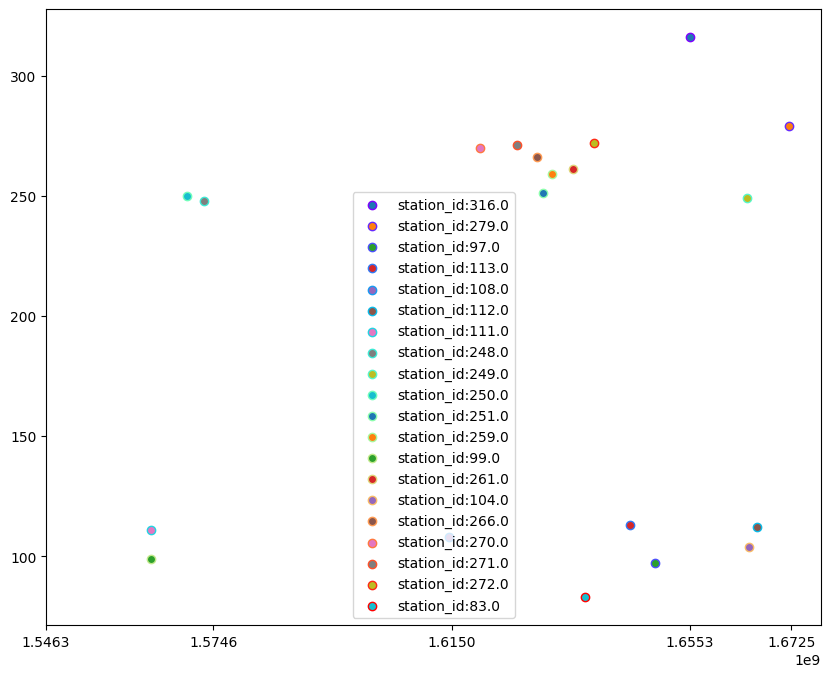

In [44]:
%%time

# case of station with opened status and is installed but it is not renting and not returning
filtered = filter_data(filtered_bbdd, status_of_station, 0)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8),
    count=20
)

value counts stats {'max': 1, 'mean': 1.0, 'median': 1.0, 'std': 0.0, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 6.78 s, sys: 883 ms, total: 7.67 s
Wall time: 48.6 s


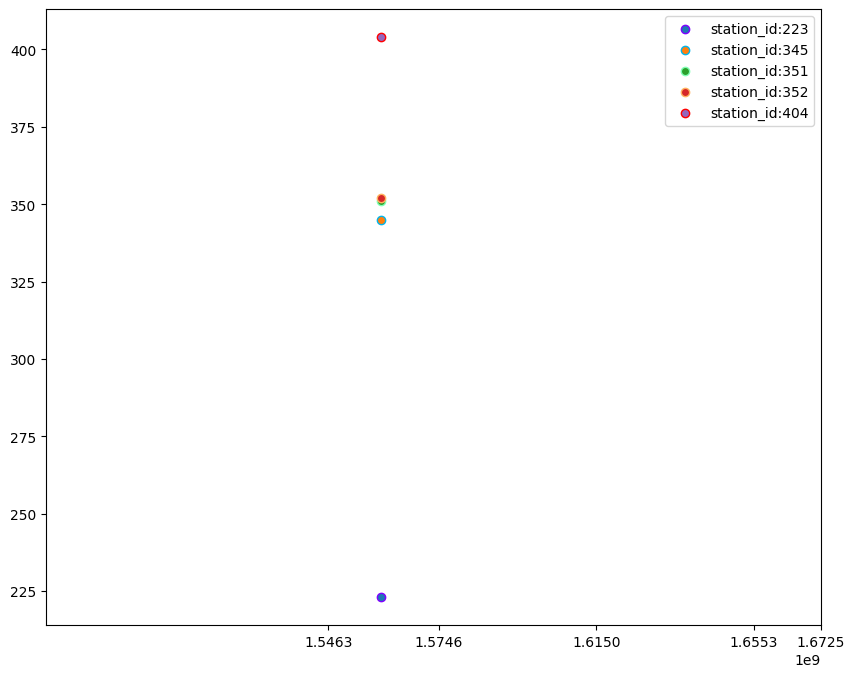

In [45]:
%%time

# case of station with opened status and is installed and is renting and returning
filtered = filter_data(filtered_bbdd, status_of_station, 1)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

value counts stats {'max': 26058, 'mean': 24972.816176470587, 'median': 25044.5, 'std': 837.2548292918759, 'min': 20336}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 7.35 s, sys: 954 ms, total: 8.31 s
Wall time: 55.9 s


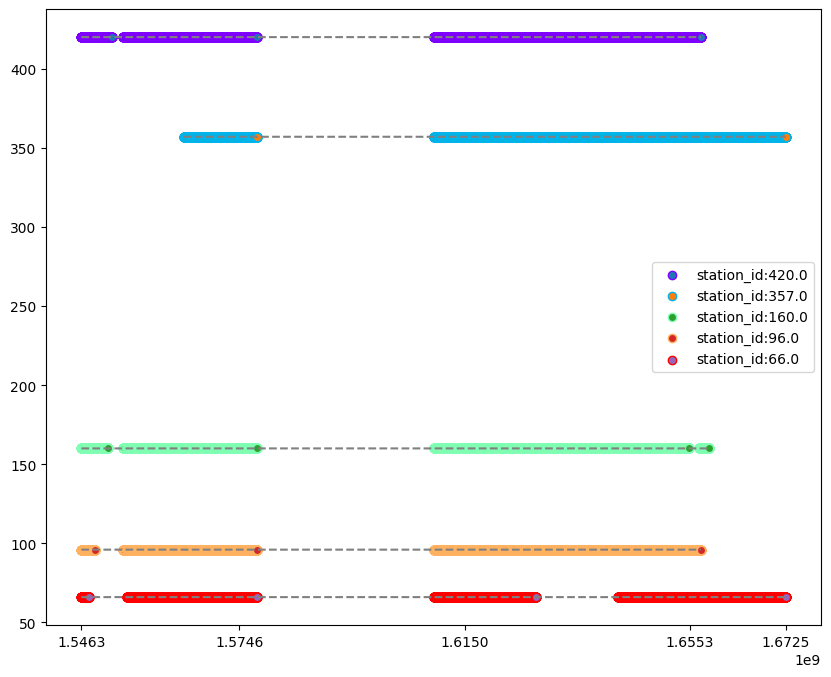

In [46]:
%%time
# case of station with opened status and is installed and is renting and returning
filtered = filter_data(filtered_bbdd, status_of_station, 2)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

value counts stats {'max': 75, 'mean': 12.446913580246914, 'median': 10.0, 'std': 10.992583980991311, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 6.8 s, sys: 868 ms, total: 7.67 s
Wall time: 45.2 s


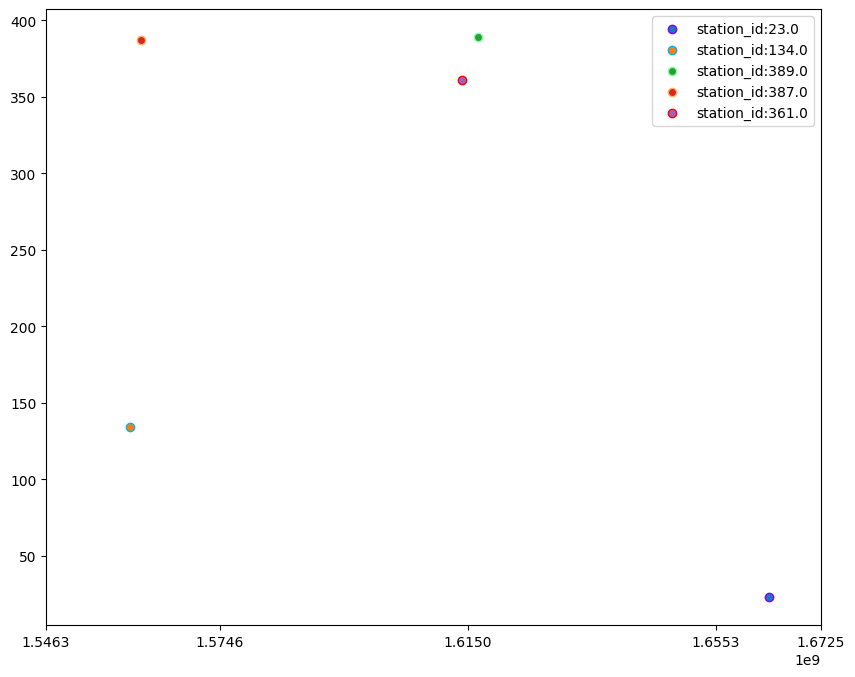

In [47]:
%%time
# case of station with opened status and is installed and is renting and returning
filtered = filter_data(filtered_bbdd, status_of_station, 3)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

value counts stats {'max': 2129, 'mean': 1059.0931372549019, 'median': 1046.0, 'std': 521.6331575056345, 'min': 181}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 6.46 s, sys: 871 ms, total: 7.34 s
Wall time: 45.9 s


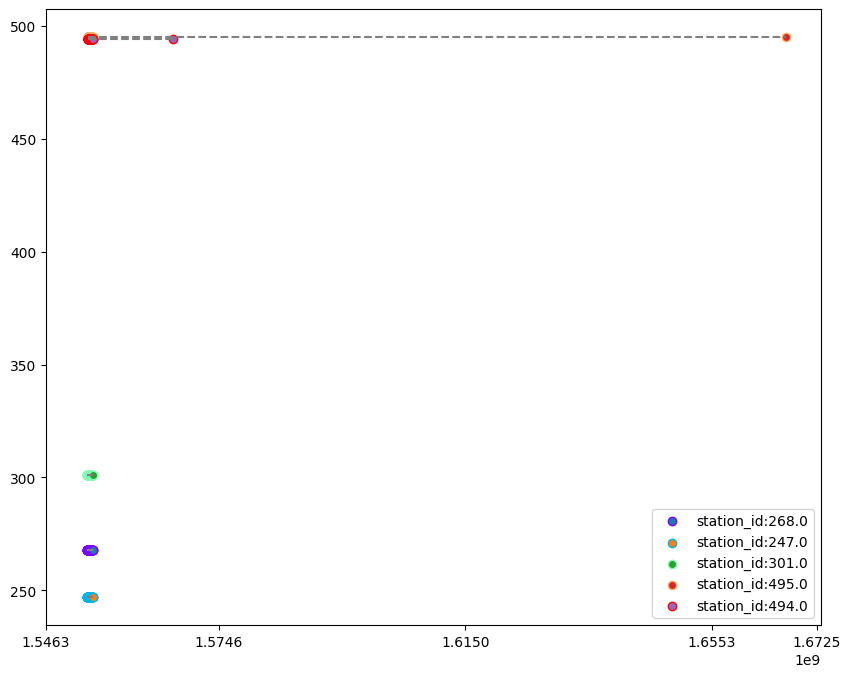

In [48]:
%%time
# case of station with opened status and is installed and is renting and returning
filtered = filter_data(filtered_bbdd, status_of_station, 4)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

value counts stats {'max': 2, 'mean': 1.2, 'median': 1.0, 'std': 0.4050957468334667, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 6.41 s, sys: 852 ms, total: 7.26 s
Wall time: 45.8 s


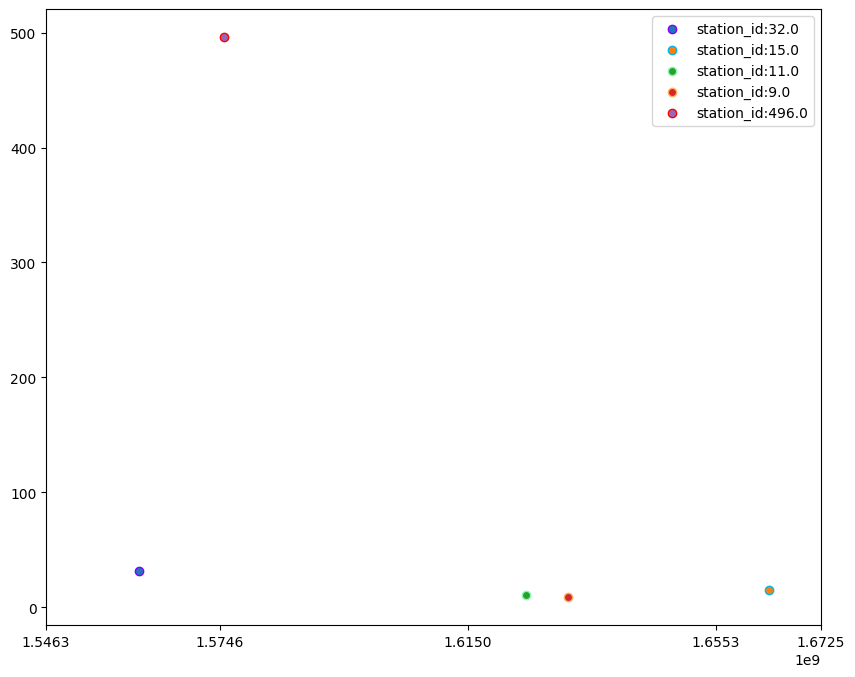

In [49]:
%%time
# case of station with opened status and is installed and is renting and returning
filtered = filter_data(filtered_bbdd, status_of_station, 5)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

value counts stats {'max': 91, 'mean': 12.196428571428571, 'median': 3.0, 'std': 18.390135342679724, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 6.61 s, sys: 806 ms, total: 7.42 s
Wall time: 46.5 s


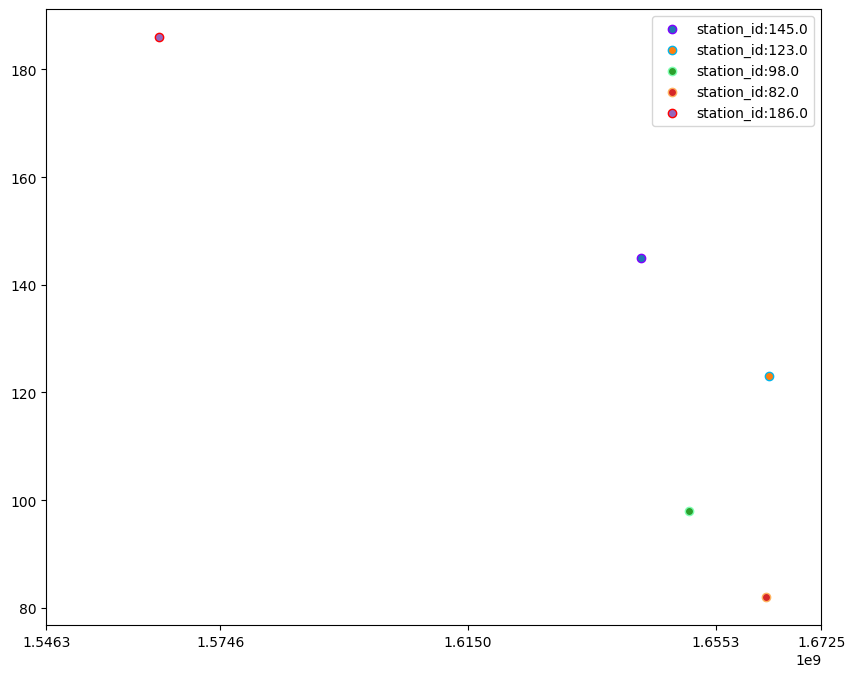

In [50]:
%%time
# case of station with opened status and is installed and is renting and returning
filtered = filter_data(filtered_bbdd, status_of_station, 6)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

value counts stats {'max': 27, 'mean': 2.925531914893617, 'median': 2.0, 'std': 3.104763463717831, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 6.49 s, sys: 880 ms, total: 7.37 s
Wall time: 47.2 s


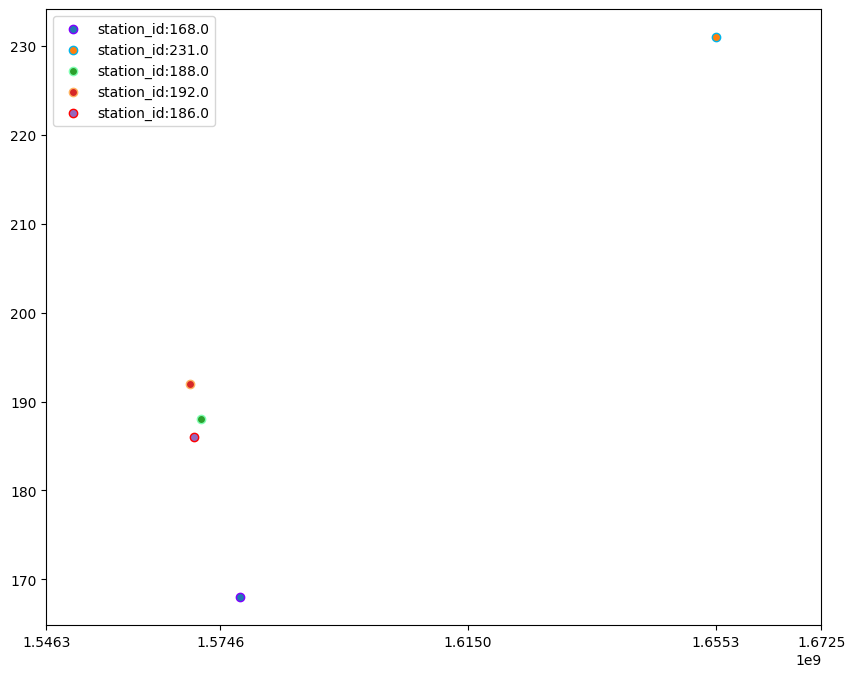

In [51]:
%%time
# case of station with opened status and is installed and is renting and returning
filtered = filter_data(filtered_bbdd, status_of_station, 7)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

# Goal Columns 

## 'num_docks_available' 

DescribeResult(nobs=10627655, minmax=(0.0, 54.0), mean=15.706517308670882, variance=75.91678951478104, skewness=0.10263839892092153, kurtosis=-0.35021592035011473)


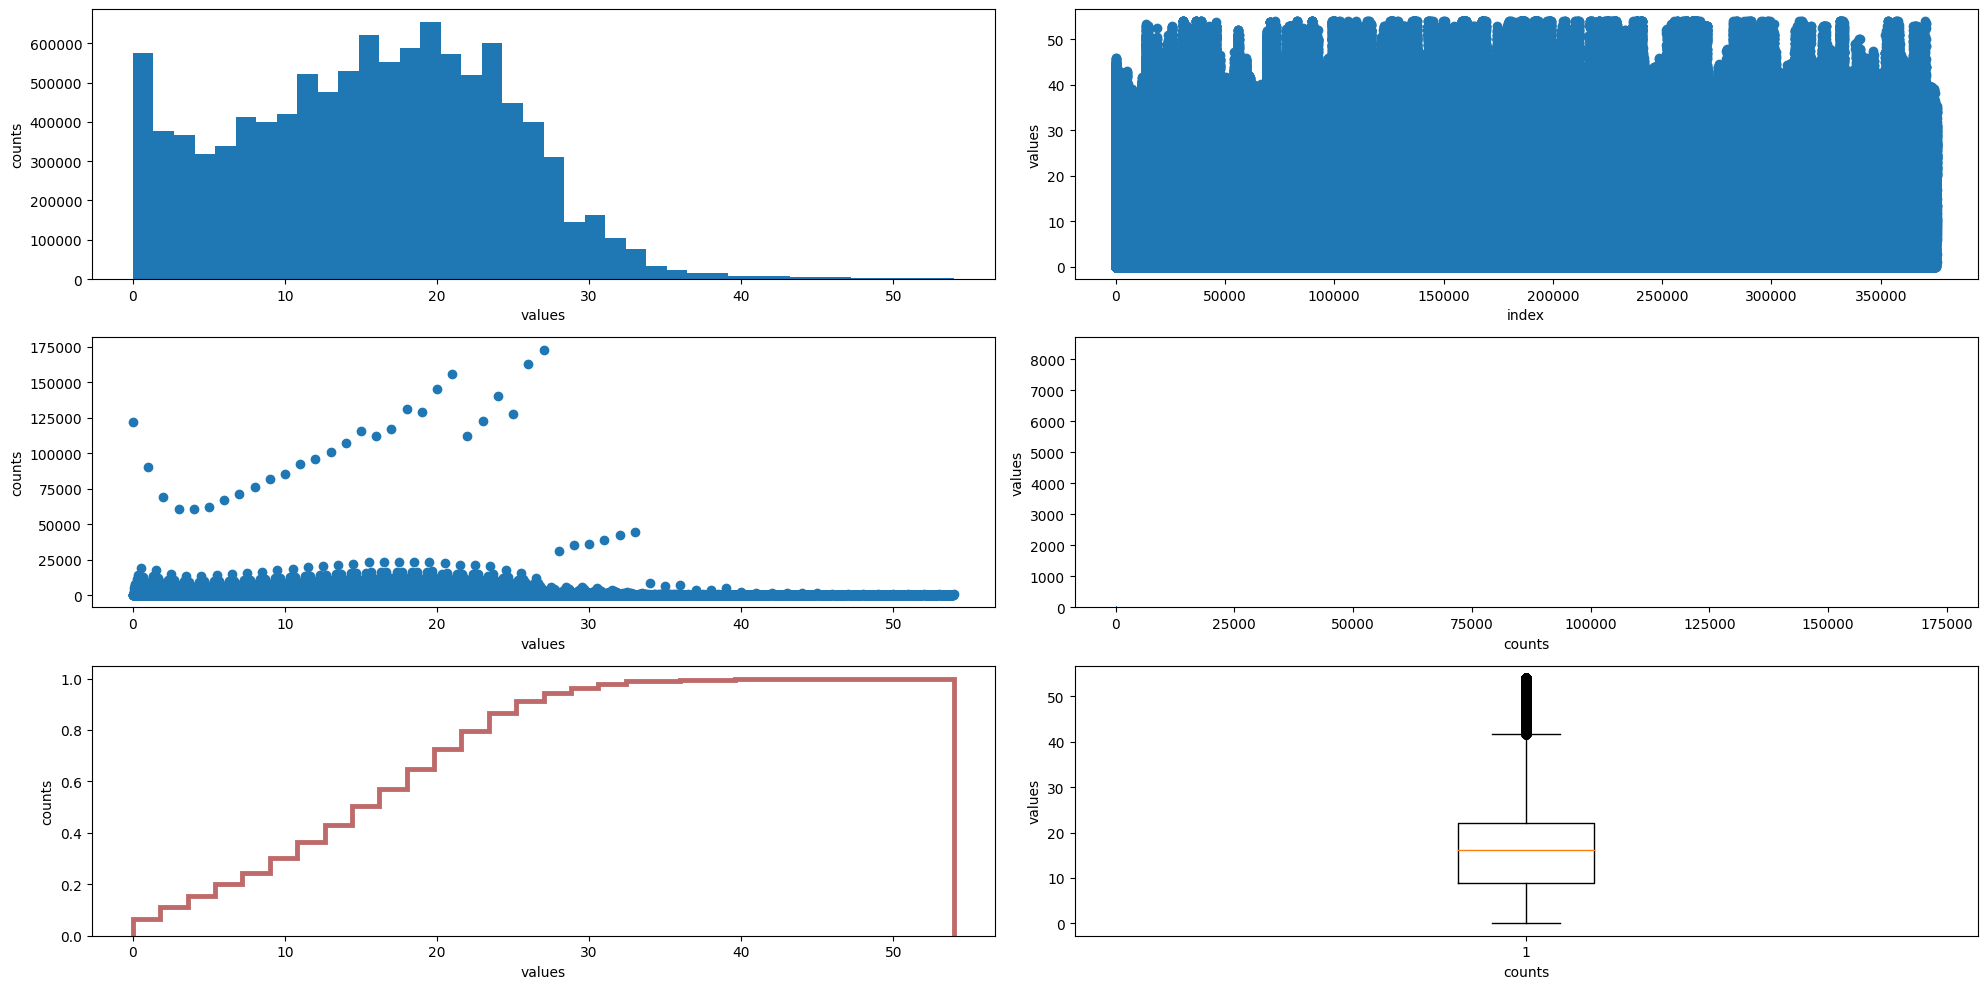

CPU times: user 30.5 s, sys: 2.88 s, total: 33.4 s
Wall time: 43.8 s


In [54]:
%%time
print(stats.describe(filtered_bbdd.num_docks_available))
filtered_bbdd.num_docks_available.describe()
show_counts(filtered_bbdd.num_docks_available.compute())

## 'num_bikes_available' 

DescribeResult(nobs=10627655, minmax=(-0.1666666666666666, 54.0), mean=9.914912113166132, variance=71.09162944954792, skewness=0.8509441612411704, kurtosis=0.4349155881252105)


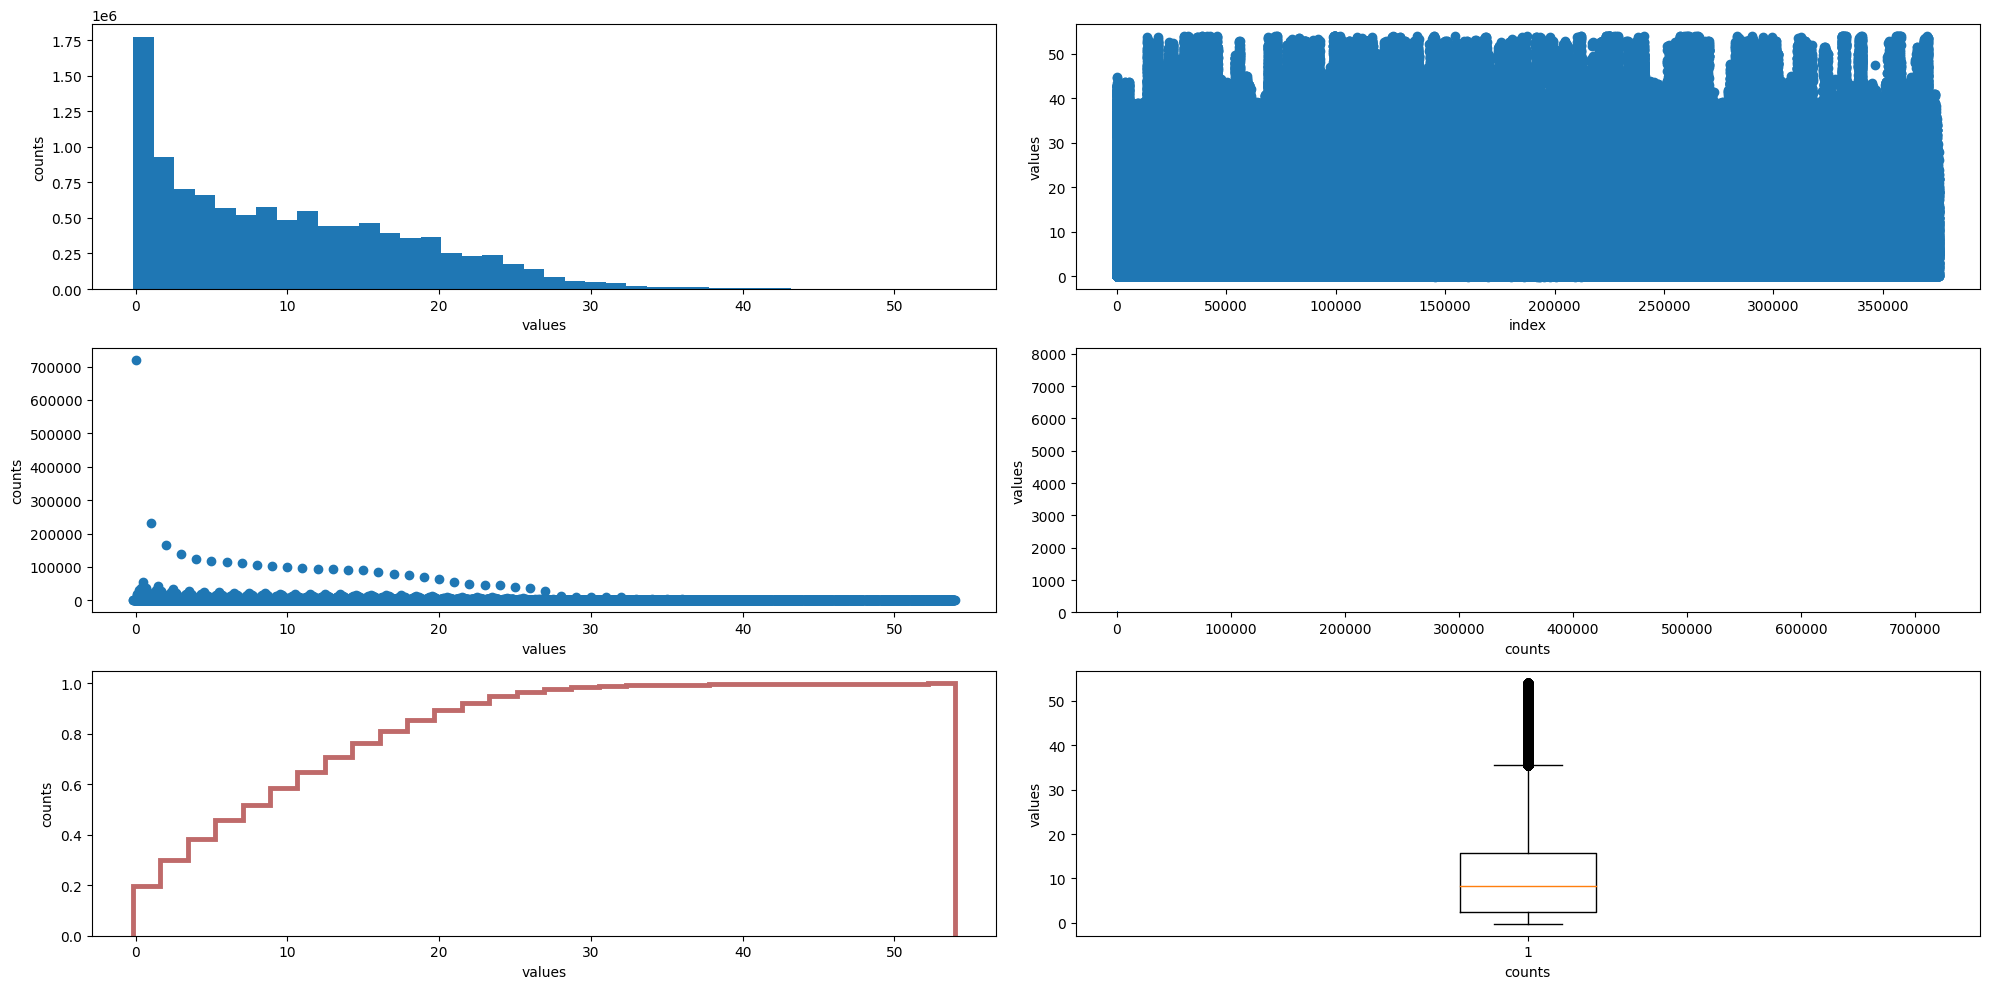

CPU times: user 28.6 s, sys: 2.52 s, total: 31.2 s
Wall time: 42.1 s


In [55]:
%%time
print(stats.describe(filtered_bbdd.num_bikes_available))
filtered_bbdd.num_bikes_available.describe()
show_counts(filtered_bbdd.num_bikes_available.compute())

## 'num_bikes_available_types.mechanical'

DescribeResult(nobs=10627655, minmax=(-0.1666666666666666, 54.0), mean=8.329227751469292, variance=66.28752638996909, skewness=0.9974734038114539, kurtosis=0.6295888877246627)


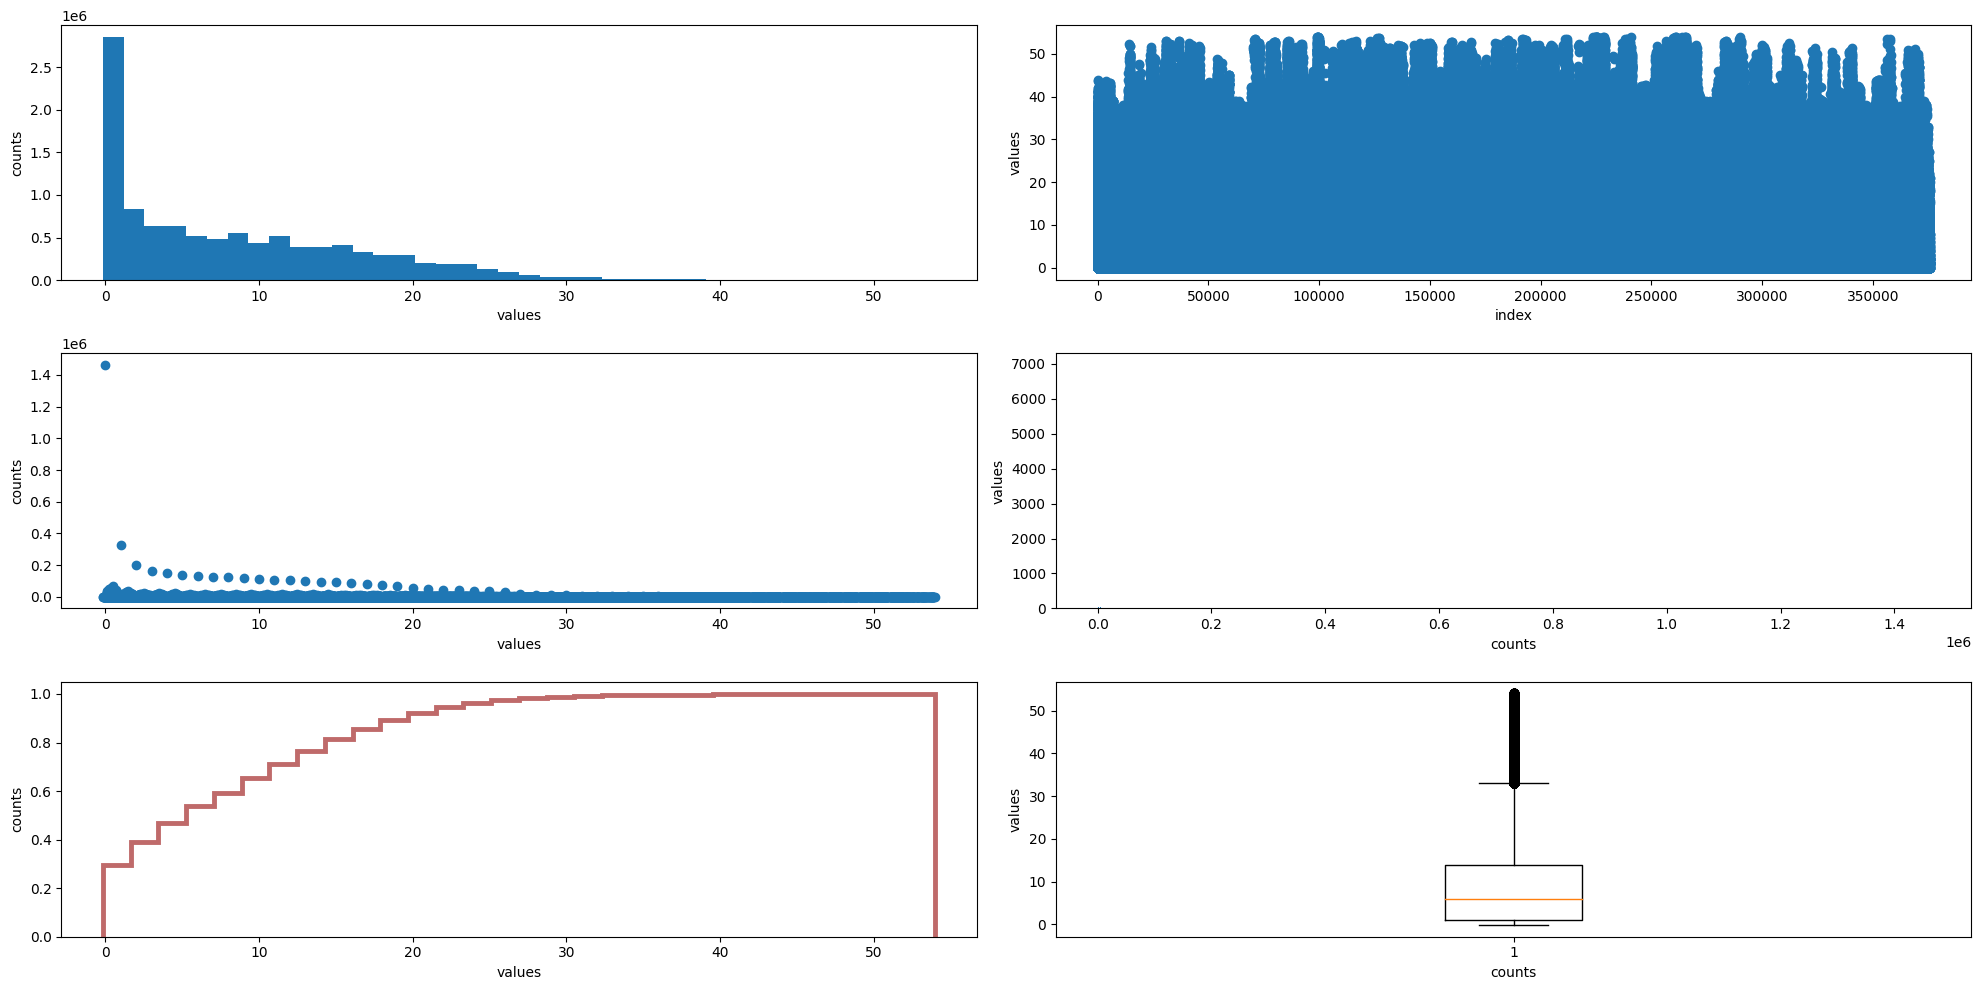

CPU times: user 27.3 s, sys: 2.47 s, total: 29.8 s
Wall time: 40.7 s


In [56]:
%%time
print(stats.describe(filtered_bbdd['num_bikes_available_types.mechanical']))
filtered_bbdd['num_bikes_available_types.mechanical'].describe()
show_counts(filtered_bbdd['num_bikes_available_types.mechanical'].compute())

## 'num_bikes_available_types.ebike'

DescribeResult(nobs=10627655, minmax=(0.0, 37.0), mean=1.5857170409151455, variance=7.1762262331396975, skewness=3.2216978279643222, kurtosis=13.926172077026898)


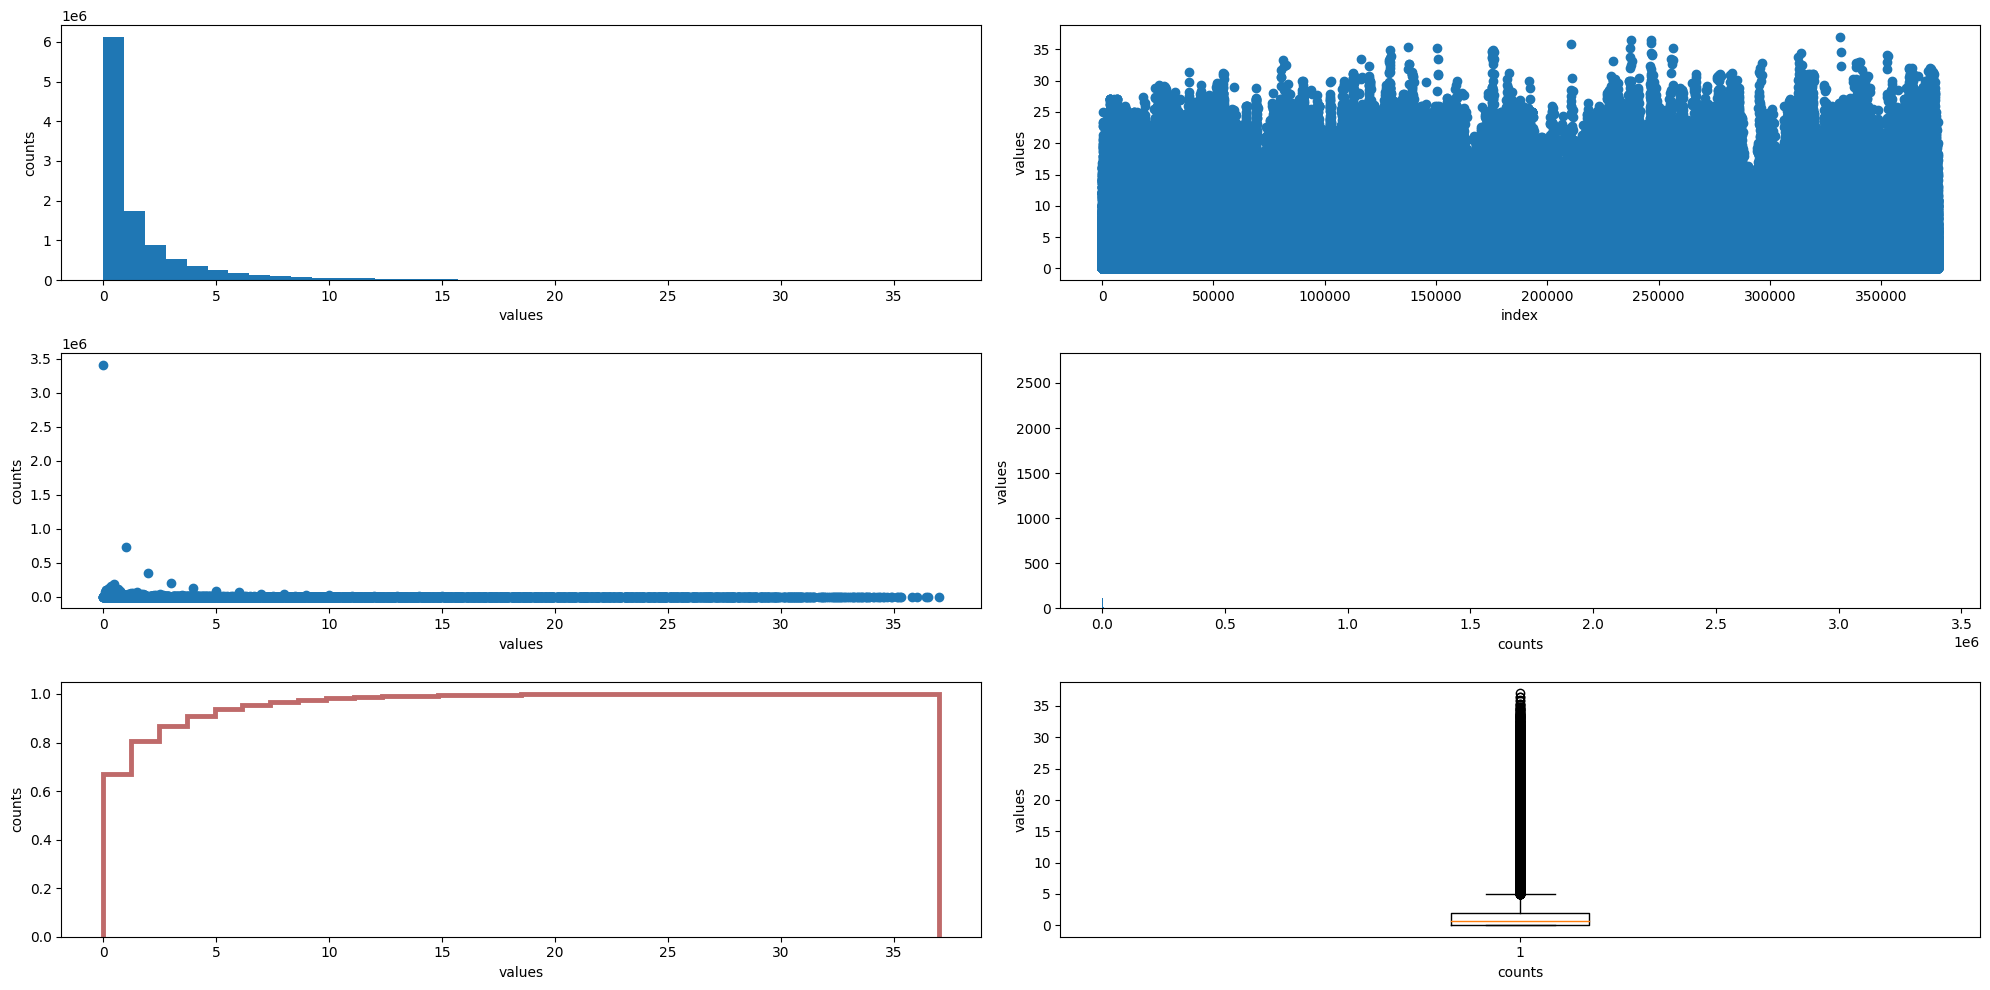

CPU times: user 22.2 s, sys: 1.56 s, total: 23.7 s
Wall time: 35.7 s


In [57]:
%%time
print(stats.describe(filtered_bbdd['num_bikes_available_types.ebike']))
filtered_bbdd['num_bikes_available_types.ebike'].describe()
show_counts(filtered_bbdd['num_bikes_available_types.ebike'].compute())

## 'capacity' 

DescribeResult(nobs=10627655, minmax=(12.000000000000004, 54.00000000000003), mean=27.380128633952904, variance=36.11629004586299, skewness=1.3286915348900465, kurtosis=3.9481077087964973)


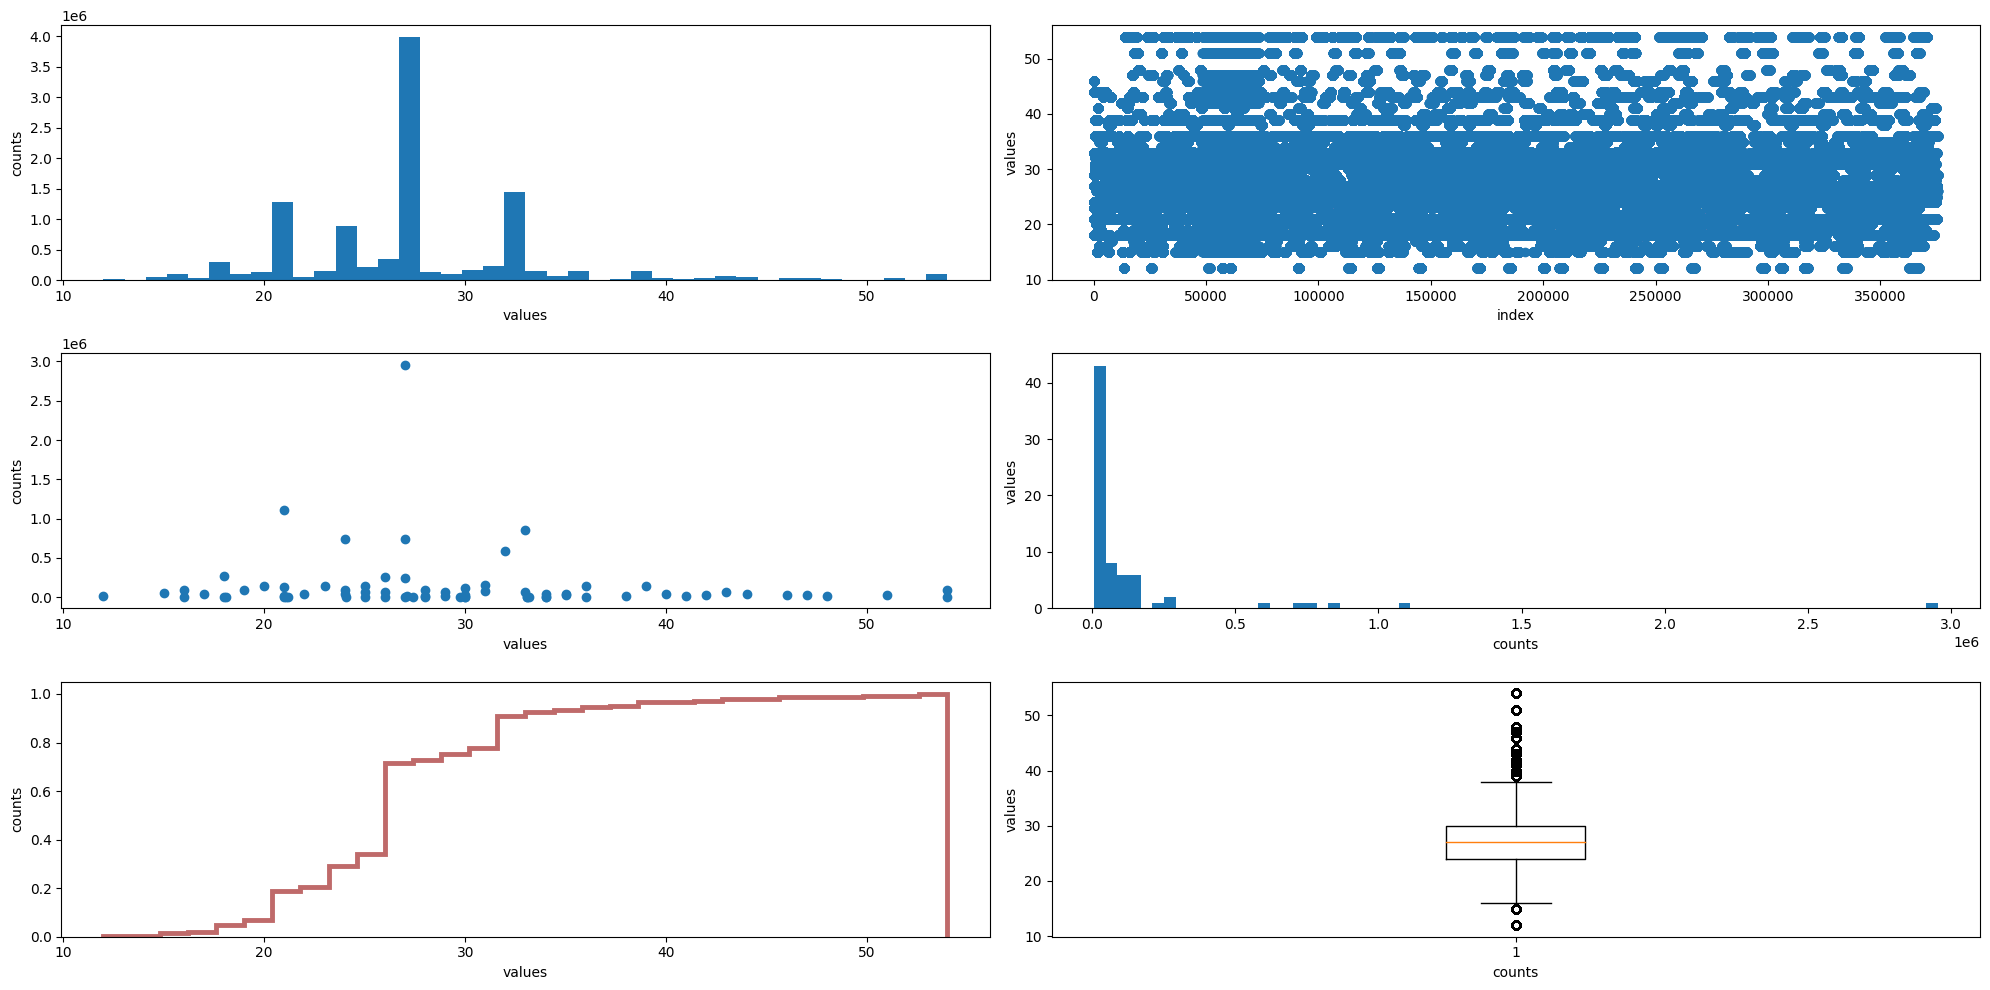

CPU times: user 18 s, sys: 1.22 s, total: 19.2 s
Wall time: 31.4 s


In [58]:
%%time
print(stats.describe(filtered_bbdd.capacity))
filtered_bbdd.capacity.describe()
show_counts(filtered_bbdd.capacity.compute())

## 'ctx0'

DescribeResult(nobs=10627655, minmax=(0.0, 1.0), mean=0.573568713082273, variance=0.08500050898954867, skewness=-0.3735336735347631, kurtosis=-1.0226674830933085)


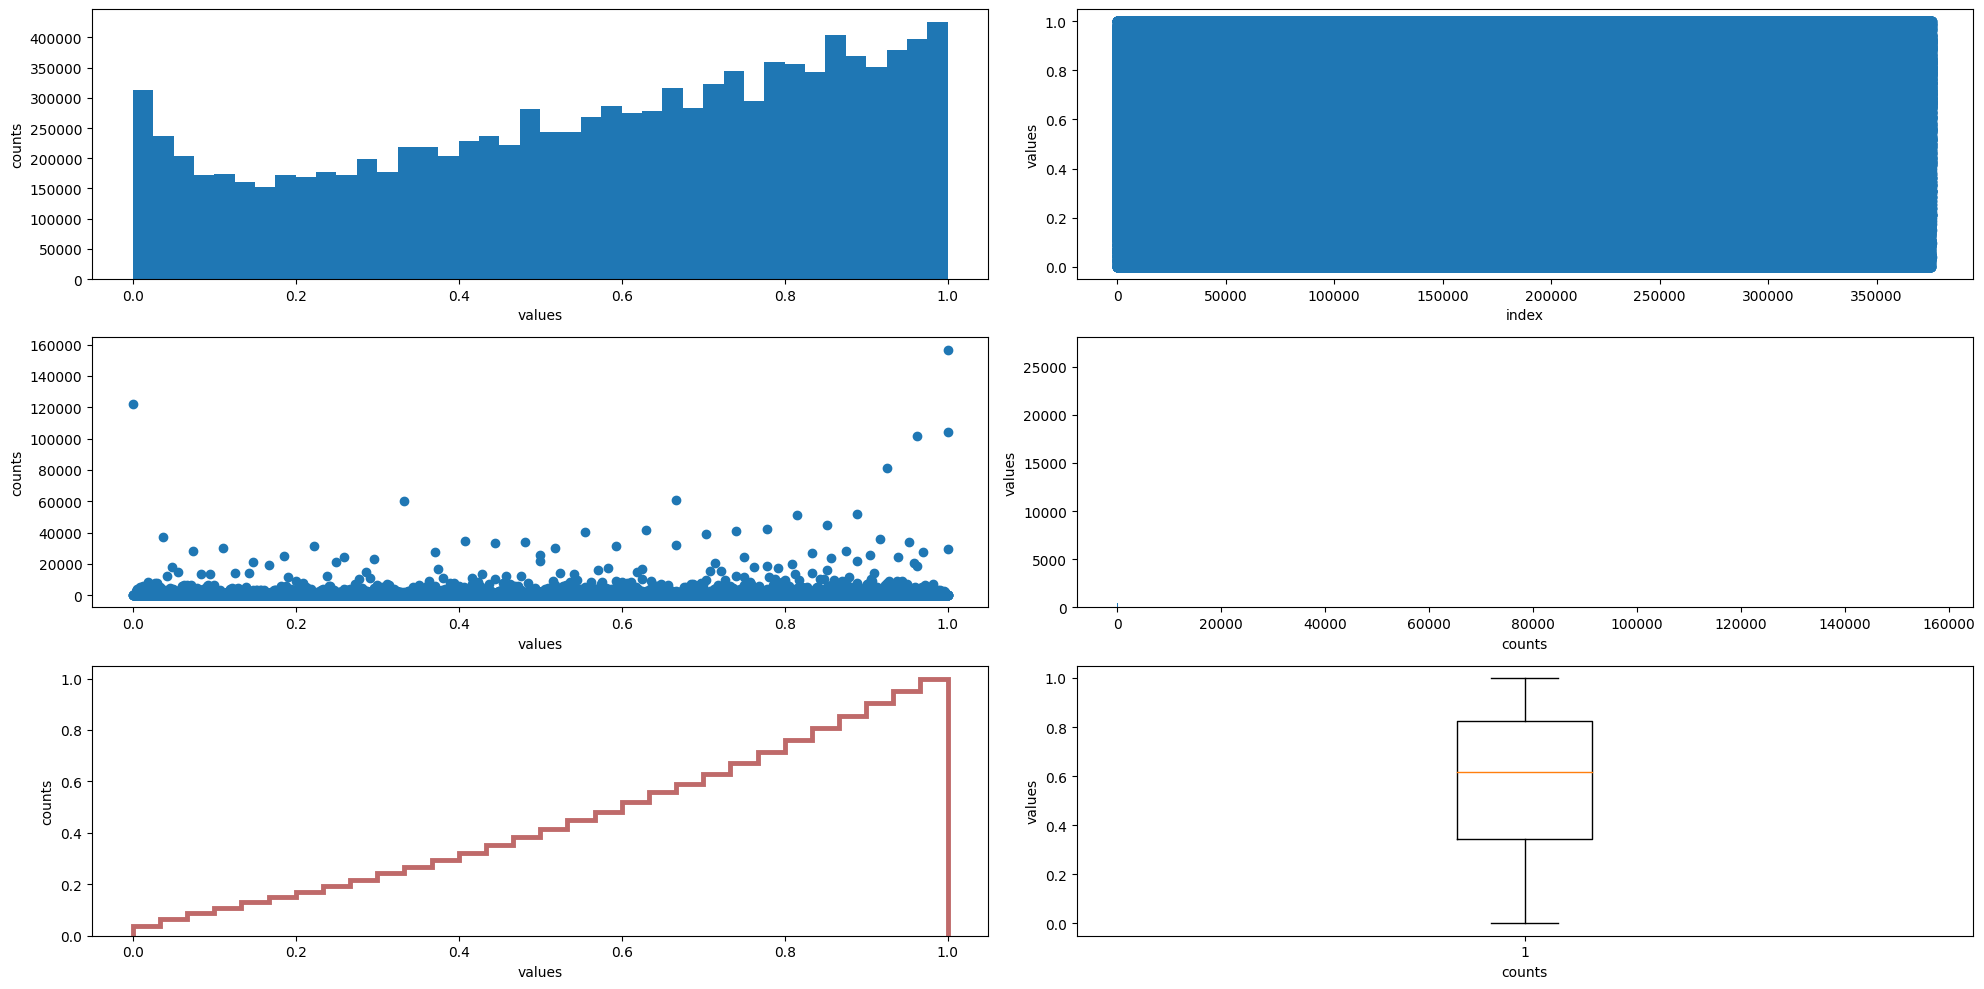

CPU times: user 1min 35s, sys: 11.5 s, total: 1min 47s
Wall time: 1min 48s


In [59]:
%%time
print(stats.describe(filtered_bbdd.ctx0))
filtered_bbdd.ctx0.describe()
show_counts(filtered_bbdd.ctx0.compute())

## · Visualización de la disponibilidad de bicicletas
Gráficos para visualizar la disponibilidad de bicicletas a lo largo del tiempo. Ejemplo: cantidad de bicicletas disponibles en función del tiempo para identificar patrones diarios, semanales o estacionales.

## · Análisis temporal
Datos por año, mes, día de la semana o hora del día para conocer estadísticas agregadas, como el promedio de bicicletas disponibles o el porcentaje de anclajes disponibles. Tendencias temporales y patrones de uso.

## · Relación entre variables
Explorar si hay una correlación entre el número de anclajes disponibles (num_docks_available) y el número de bicicletas disponibles (num_bikes_available). Investigar si la disponibilidad de bicicletas difiere entre los diferentes tipos de bicicletas (mecánicas y eléctricas).

## · Análisis de capacidad y porcentaje de anclajes disponibles
Capacidad (capacity) y los porcentajes de anclajes disponibles (ctx0, ctx1, ctx2, ctx3, ctx4). Promedio distribución de la capacidad y los porcentajes de anclajes disponibles. Objetivo: entender la utilización de las estaciones de bicicletas a lo largo del tiempo.

In [ ]:
.
Continue from here

## Data Cleaning

In [20]:
%%time

stations = filtered_bbdd[['timestamp', 'station_id', 'ctx0']].compute()

CPU times: user 1.13 s, sys: 559 ms, total: 1.69 s
Wall time: 8.09 s


In [21]:
%%time 

# test 

cond = stations.station_id.isin([1])
station_data = stations[cond]
station_group = station_data.groupby(['timestamp', 'station_id'])
station_counts = station_group.ctx0.count()
station_mean = station_group.ctx0.mean()
(station_counts > 1).any()

CPU times: user 423 ms, sys: 6.68 ms, total: 430 ms
Wall time: 405 ms


True

In [22]:
station_counts = station_counts.reset_index()
station_counts

,timestamp,station_id,ctx0
0,1.546301e+09,1.0,1
1,1.546304e+09,1.0,1
2,1.546308e+09,1.0,1
3,1.546312e+09,1.0,1
4,1.546315e+09,1.0,1
...,...,...,...
25939,1.672513e+09,1.0,1
25940,1.672517e+09,1.0,1
25941,1.672520e+09,1.0,1
25942,1.672524e+09,1.0,1


In [23]:
station_counts.timestamp.to_list()

[1546300800.0,
 1546304400.0,
 1546308000.0,
 1546311600.0,
 1546315200.0,
 1546318800.0,
 1546322400.0,
 1546326000.0,
 1546329600.0,
 1546333200.0,
 1546336800.0,
 1546340400.0,
 1546344000.0,
 1546347600.0,
 1546351200.0,
 1546354800.0,
 1546358400.0,
 1546362000.0,
 1546365600.0,
 1546369200.0,
 1546372800.0,
 1546376400.0,
 1546380000.0,
 1546383600.0,
 1546387200.0,
 1546390800.0,
 1546394400.0,
 1546398000.0,
 1546401600.0,
 1546405200.0,
 1546408800.0,
 1546412400.0,
 1546416000.0,
 1546419600.0,
 1546423200.0,
 1546426800.0,
 1546430400.0,
 1546434000.0,
 1546437600.0,
 1546441200.0,
 1546444800.0,
 1546448400.0,
 1546452000.0,
 1546455600.0,
 1546459200.0,
 1546462800.0,
 1546466400.0,
 1546470000.0,
 1546473600.0,
 1546477200.0,
 1546480800.0,
 1546484400.0,
 1546488000.0,
 1546491600.0,
 1546495200.0,
 1546498800.0,
 1546502400.0,
 1546506000.0,
 1546509600.0,
 1546513200.0,
 1546516800.0,
 1546520400.0,
 1546524000.0,
 1546527600.0,
 1546531200.0,
 1546534800.0,
 154653840

In [24]:
station_mean = station_mean.reset_index()
station_mean

,timestamp,station_id,ctx0
0,1.546301e+09,1.0,0.181818
1,1.546304e+09,1.0,0.156126
2,1.546308e+09,1.0,0.164032
3,1.546312e+09,1.0,0.191700
4,1.546315e+09,1.0,0.104743
...,...,...,...
25939,1.672513e+09,1.0,0.125604
25940,1.672517e+09,1.0,0.111801
25941,1.672520e+09,1.0,0.119565
25942,1.672524e+09,1.0,0.158385


In [25]:
station_mean[(station_counts.ctx0 > 1)]

,timestamp,station_id,ctx0
743,1.548976e+09,1.0,0.630435
744,1.548979e+09,1.0,0.630435
745,1.548983e+09,1.0,0.630435
746,1.548986e+09,1.0,0.630435
747,1.548990e+09,1.0,0.630435
...,...,...,...
25199,1.669849e+09,1.0,0.396739
25200,1.669853e+09,1.0,0.327899
25201,1.669856e+09,1.0,0.302536
25202,1.669860e+09,1.0,0.304348


In [26]:
%%time

stations = filtered_bbdd[['timestamp', 'station_id', 'ctx0']].compute()

CPU times: user 1.15 s, sys: 450 ms, total: 1.6 s
Wall time: 7.99 s


In [27]:
stations.columns

Index(['timestamp', 'station_id', 'ctx0'], dtype='object')

In [28]:
get_ddf_shape(filtered_bbdd)

(10627655, 22)

In [29]:
stations.shape

(10627655, 3)

In [30]:
stations.drop_duplicates(subset=['timestamp', 'station_id'], keep='last', inplace=True)

In [31]:
stations.shape

(10526888, 3)

In [32]:
stations.index.to_list()

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


## Cleaning

In [33]:
type(filtered_bbdd)

dask.dataframe.core.DataFrame

In [34]:
filtered_bbdd1 = filtered_bbdd.drop_duplicates(subset=['timestamp', 'station_id'], keep='last')

In [35]:
get_ddf_shape(filtered_bbdd1)

(10526888, 22)

# Predicción__________________________________
a) Regresión lineal: relación lineal entre las variables de entrada y la variable de salida. 

b) Regresión Redes Neuronales (RNN -redes neuronales recurrentes-): pueden capturar relaciones no lineales entre las variables de entrada y salida.

In [ ]:
def get_pipeline(args):
    num0_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),
        ('log',FunctionTransformer(np.log1p, validate=True)),
        ('std_scaler', StandardScaler()),
    ])

    num1_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),
        ('rep',FunctionTransformer(np.log1p, validate=True)),# Cambie el reciprocal por el log1p pero al parecer para valores que no tienen historia se afecta mucho
        ('std_scaler', StandardScaler()),
    ])
    
    num2_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),
#         ('rep',FunctionTransformer(np.reciprocal, validate=True)),
        ('std_scaler', StandardScaler()),
    ])

    cat0_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant",fill_value='Unknown')),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ])

    cat1_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
#         ('std_scaler', StandardScaler()),
    ])

    ## the features
    weather_columns_by_months = [ 
        "EROSION_SUELO","PrecipAmountLocalMonth","TemperatureLocalMonthtimeMax","UVIndexLocalMonthMax"
    ]
    
    num_attribs0 = ["SUPERFICIE"]
    num_attribs2 = ["MALTITUD"]
    # num_attribs1 = weather_columns_by_months
    cat_attribs0 = ["RANGO_ALTITUD","VARIEDAD","ID_ESTACION","ID_ZONA","ID_FINCA", 'MODO']
    cat_attribs1 = ['TIPO','COLOR']
    
    full_pipeline = ColumnTransformer([
        ("num0", num0_pipeline, num_attribs0),
        ("num2", num2_pipeline, num_attribs2),
        ("cat0", cat0_pipeline, cat_attribs0),
        ("cat1", cat1_pipeline, cat_attribs1),
    ])
    
    return full_pipeline

def apply_pipeline(x_train,x_test,y_train,y_test, show=True):
    
    full_pipeline = get_pipeline({'campaña_catagories':[x_train.CAMPAÑA.unique().tolist() +x_test.CAMPAÑA.unique().tolist()],'fill_value':x_test.CAMPAÑA.unique()[-1],'unknown_value':x_train.CAMPAÑA.unique().shape[0]})

    x_train_prepared = full_pipeline.fit_transform(x_train)
    x_test_prepared = full_pipeline.transform(x_test)
    
    if show:
        print("x_train_prepared:",x_train_prepared.shape,"y_train: ",y_train.shape)
        print("x_test_prepared:",x_test_prepared.shape,"y_test: ",y_test.shape)

    return x_train_prepared,x_test_prepared,y_train,y_test

def split_data(X, show=True):
    
    df = X.copy()
    
    cond_train = df.CAMPAÑA<df.CAMPAÑA.unique()[-1]
    cond_test = df.CAMPAÑA.isin([df.CAMPAÑA.unique()[-1]])

    x_train = df[cond_train].loc[:,~df.columns.isin(["PRODUCCION"])]
    x_test = df[cond_test].loc[:,~df.columns.isin(["PRODUCCION"])]
    y_train = df[cond_train].loc[:,df.columns.isin(["PRODUCCION"])]
    y_test = df[cond_test].loc[:,df.columns.isin(["PRODUCCION"])]
    
    if show:
        print("x_train:",x_train.shape,"y_train: ",y_train.shape)
        print("x_test:",x_test.shape,"y_test: ",y_test.shape)
    
    return x_train,x_test,y_train,y_test

In [ ]:
df = data[~data.CAMPAÑA.isin([22,14])]
x_train,x_test,y_train,y_test = split_data(df)
x_train_prepared,x_test_prepared,y_train,y_test = apply_pipeline(x_train,x_test,y_train,y_test)


In [ ]:
final_model = RandomForestRegressor(max_depth=100, min_samples_split=4,random_state=42, n_estimators=60) #(OK)

# final_model = GradientBoostingRegressor(max_depth=22, min_samples_split=2,min_samples_leaf=2, max_features= 'sqrt',random_state=0) #(OK)

final_model.fit(x_train_prepared,y_train)

test_model(final_model, x_train_prepared, y_train, x_test_prepared, y_test)

pred = final_model.predict(x_test_prepared)

df["PRODUCCION_PRED"] = df["PRODUCCION"].copy()
df.loc[x_test.index,"PRODUCCION_PRED"]=pred


# Datos adicionales
Tiempo, festivos Barcelona